**Important**: This notebook only works together with the oggm dev branch at the moment

# Add Surface Type observations to Datacubes

Here I demonstrate the workflow for adding surface type observations to the Datacube. This code should be added to https://github.com/DTC-Glaciers/dtcg, following a similar approach to how the eolis data is integrated into the Datacubes.

## Initialize a gdir as an example

In [1]:
from oggm import utils, workflow, cfg, tasks, DEFAULT_BASE_URL

In [2]:
cfg.initialize()

working_dir = 'working_dir_sfc_type'
utils.mkdir(working_dir)
cfg.PATHS['working_dir'] = working_dir

2025-10-03 09:46:04: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-10-03 09:46:04: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-03 09:46:04: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [3]:
rgi_ids = ['RGI60-11.00719',  # Vernagtferner
           #'RGI60-11.00897',  # Hintereisferner
          ]
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? 
    prepro_border=80  # how big of a map?
)
gdir = gdirs[0]

2025-10-03 09:46:04: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2025-10-03 09:46:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## add surface type observation to gridded data

For simplicity, instead of creating a lookup table for the original observation files, I merged them for our region of interest in Austria (only two files per timestamp). If there is still time for further development, we could add the option to use the original files by creating a lookup table.

In [4]:
import xarray as xr
import salem
import numpy as np
import pandas as pd
import warnings
import requests
from bs4 import BeautifulSoup

In [5]:
# This function is based on oggm.shop.millan22._filter_and_reproj
def reproject_single_sfc_type_file(gdir, input_file):
    # Subset to avoid mega files
    dsb = salem.GeoTiff(input_file)
    
    x0, x1, y0, y1 = gdir.grid.extent_in_crs(dsb.grid.proj)
    with warnings.catch_warnings():
        # This can trigger an out of bounds warning
        warnings.filterwarnings("ignore", category=RuntimeWarning,
                                message='.*out of bounds.*')
        dsb.set_subset(corners=((x0, y0), (x1, y1)),
                       crs=dsb.grid.proj,
                       margin=5)
    
    data_sfc_types = dsb.get_vardata(var_id=1)
    data_uncertainty = dsb.get_vardata(var_id=2)
    
    # Reproject now
    with warnings.catch_warnings():
        # This can trigger an out of bounds warning
        warnings.filterwarnings("ignore", category=RuntimeWarning,
                                message='.*out of bounds.*')
        r_data_sfc_types = gdir.grid.map_gridded_data(data_sfc_types, dsb.grid, interp='nearest')
        r_data_uncertainty = gdir.grid.map_gridded_data(data_uncertainty, dsb.grid, interp='nearest')

    return r_data_sfc_types.data, r_data_uncertainty.data

In [6]:
def add_sfc_type_observation(gdir, data_base_url):
    # open gridded data
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()

    # get all available files of observations from the url, only one per day
    response = requests.get(data_base_url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    files_used = []
    sfc_type_dates = []
    for link in soup.find_all("a", href=True):
        file = link['href']
        if file.lower().endswith('.tif'):
            date = file.split('_')[0]
            if date in sfc_type_dates:
                # their is already an observation for this date available
                raise ValueError(f'Surface type for {date} already added! '
                                 'Check the provided input files, for each '
                                 'date only one should be provided!')
            sfc_type_dates.append(date)
            files_used.append(file)

    # prepare structure for data
    sfc_type_data = np.zeros((len(sfc_type_dates), *ds['glacier_mask'].shape))
    sfc_type_uncertainty = np.zeros((len(sfc_type_dates), *ds['glacier_mask'].shape))

    # loop through all files and add one after the other
    for i, filename in enumerate(files_used):
        # download data
        input_file = utils.file_downloader(data_base_url + filename)
        
        r_data, r_uncertainty = reproject_single_sfc_type_file(gdir, input_file)
        sfc_type_data[i, :] = r_data
        sfc_type_uncertainty[i, :] = r_uncertainty

    # use nan for missing data
    missing_data_val = np.nan
    sfc_type_data = np.where(sfc_type_data == 255,
                             missing_data_val, sfc_type_data)
    sfc_type_uncertainty = np.where(sfc_type_uncertainty == 255,
                                    missing_data_val, sfc_type_uncertainty)

    # add to gridded data with some attributes
    ds.coords['t_sfc_type'] = pd.to_datetime(sfc_type_dates, format="%Y%m%d")

    ds['t_sfc_type'].attrs = {
        'long_name': 'Timestamp of surface type observations'
    }
    ds['sfc_type_data'] = (('t_sfc_type', 'y', 'x'), sfc_type_data)
    ds['sfc_type_data'].attrs = {
        'long_name': 'Glacier facies classification',
        'data_source': 'ENVEO',
        'units': 'none',
        'code_description': 'Extract dict with ast.literal_eval(ds.code).',
        'code': str({
            0: 'unclassified',
            1: 'snow',
            2: 'firn / old snow / bright ice',
            3: 'clean ice',
            4: 'debris',
            5: 'cloud',
            'nan': 'no data',
        }),
    }

    ds['sfc_type_uncertainty'] = (('t_sfc_type', 'y', 'x'), sfc_type_uncertainty)
    ds['sfc_type_uncertainty'].attrs = {
        'long_name': 'Glacier facies classification uncertainty',
        'data_source': 'ENVEO',
        'units': 'none',
        'code_description': 'Extract dict with ast.literal_eval(ds.code).',
        'code': str({
            1: 'low uncertainty for illuminated pixel',
            2: 'medium uncertainty for illuminated pixel',
            3: 'high uncertainty for illuminated pixel',
            5: 'cloud',
            11: 'low uncertainty for shaded pixel',
            12: 'medium uncertainty for shaded pixel',
            13: 'high uncertainty for shaded pixel',
            'nan': 'no data',
        }),
    }

    ds = ds.sortby('t_sfc_type')

    ds.to_netcdf(gdir.get_filepath('gridded_data'))

    return ds

In [7]:
data_base_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/austria/sfc_type_obs/merged_data/'
ds_test = add_sfc_type_observation(gdir, data_base_url)

In [8]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

In [9]:
ds

<xarray.Dataset>
Dimensions:               (x: 254, y: 229, t_sfc_type: 82)
Coordinates:
  * x                     (x) float32 -6.412e+03 -6.361e+03 ... 6.491e+03
  * y                     (y) float32 5.197e+06 5.197e+06 ... 5.185e+06
  * t_sfc_type            (t_sfc_type) datetime64[ns] 2015-07-04 ... 2021-09-25
Data variables:
    topo                  (y, x) float32 1.849e+03 1.807e+03 ... 2.194e+03
    topo_smoothed         (y, x) float32 1.816e+03 1.8e+03 ... 2.226e+03
    topo_valid_mask       (y, x) int8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask          (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext           (y, x) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    sfc_type_data         (t_sfc_type, y, x) float64 nan nan nan ... nan nan nan
    sfc_type_uncertainty  (t_sfc_type, y, x) float64 nan nan nan ... nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=10.818 +k=0.9996 +x_0=0 +y_0=...
    max_h_dem:      3733.0
    min_h_dem:      1718.0
    max_h_glacier:  3567.0
    min_h_glacier:  2814.0

{0: 'unclassified', 1: 'snow', 2: 'firn / old snow / bright ice', 3: 'clean ice', 4: 'debris', 5: 'cloud', 'nan': 'no data'}


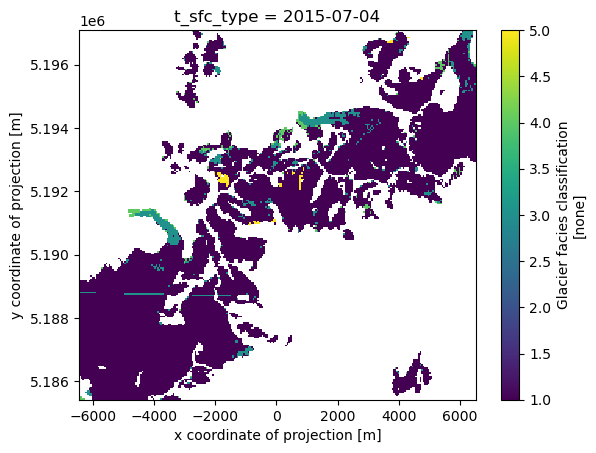

In [10]:
import ast
ds.sfc_type_data.isel(t_sfc_type=0).plot()
print(ast.literal_eval(ds.sfc_type_data.code))

{1: 'low uncertainty for illuminated pixel', 2: 'medium uncertainty for illuminated pixel', 3: 'high uncertainty for illuminated pixel', 5: 'cloud', 11: 'low uncertainty for shaded pixel', 12: 'medium uncertainty for shaded pixel', 13: 'high uncertainty for shaded pixel', 'nan': 'no data'}


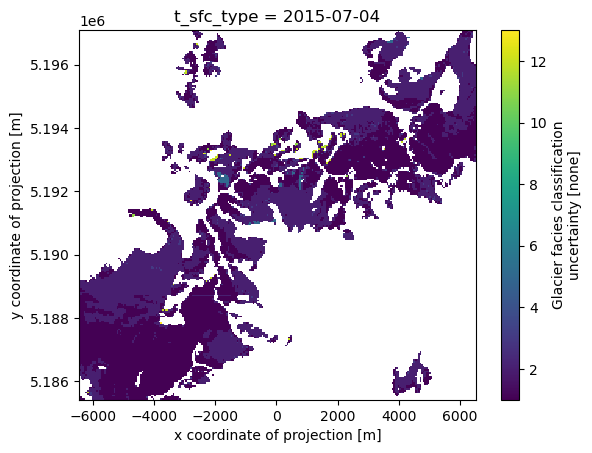

In [11]:
ds.sfc_type_uncertainty.isel(t_sfc_type=0).plot()
print(ast.literal_eval(ds.sfc_type_uncertainty.code))

# Generate a snow line observation

This part prepares the surface type observations to be used during calibration by generating a snowline altitude. In terms of `dtcg`, this is equivalent to creating a time series from the eolis gridded data, making the gridded observations usable for model calibration.

**This is still under development and will likely need further refinement, depending on the time available for additional work.**

Current approach:
- If more than 50% of the total area is cloud-covered, the date will be ignored.
- Calculate the relative snow cover area fraction per elevation bin (ignoring cloud-covered pixels).
- Use three thresholds (25%, 50%, and 75%) to extract the snowline altitude along with an associated uncertainty.
- Currently, the provided pixel uncertainty is ignored.

## Define elevation bands used for snow line creation

Here, we define elevation bands using the model flowline and also include the maximum and minimum values of the DEM to ensure that no observations are missed.

In [12]:
def get_elev_band_edges(gdir, topo_data='topo_smoothed'):
    # load flowline
    fl_inv = gdir.read_pickle('inversion_flowlines')
    assert len(fl_inv) == 1, 'Only works with one flowline.'
    fl_inv = fl_inv[0]

    # get max and min height of glacier outline
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        glacier_topo_flat = ds[topo_data].data[ds.glacier_mask.astype(bool)]
        max_glacier_elevation = np.max(glacier_topo_flat)
        min_glacier_elevation = np.min(glacier_topo_flat)

    # define edges just in between two surface heights
    sfc_h = fl_inv.surface_h
    mid = (sfc_h[:-1] + sfc_h[1:]) / 2
    elev_band_edges = np.concatenate(
        [[max_glacier_elevation * 1.01],  # upper edge, add a little to contain all values
         mid,
         [min_glacier_elevation * 0.99],  # lower edge, subtract a little to contain all values
        ]
    )

    return elev_band_edges

In [13]:
elev_band_edges = get_elev_band_edges(gdir)

In [14]:
elev_band_edges

array([3563.78376709, 3500.99729934, 3475.38321223, 3455.53270592,
       3435.51346985, 3406.3001613 , 3371.15116819, 3336.29807654,
       3302.48828803, 3271.23122264, 3241.22243016, 3212.62426943,
       3185.72058298, 3160.15784849, 3136.37567545, 3114.10171109,
       3092.93901759, 3072.91856645, 3054.01310389, 3036.48596897,
       3019.75595458, 3002.43547331, 2984.30220585, 2965.47695765,
       2946.23275942, 2926.4222284 , 2905.51917058, 2883.04061531,
       2860.97359102, 2841.78025411, 2826.35303129, 2789.87704102])

## Count surface types and uncertainty flags per elevation band

In [15]:
def get_categories_per_elevation_band(gdir,
                                      topo_data='topo_smoothed',
                                      category_data='sfc_type_data',
                                      category_uncertainty='sfc_type_uncertainty',
                                      category_time_var='t_sfc_type',
                                      nodata_value = np.nan,
                                     ):
    
    # open needed data for aggregation
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        elevations = ds[topo_data].data[ds.glacier_mask.astype(bool)]
        categories = ds[category_data].data[:,ds.glacier_mask.astype(bool)]
        categories_attrs = ds[category_data].attrs
        uncertainties = ds[category_uncertainty].data[:,ds.glacier_mask.astype(bool)]
        uncertainties_attrs = ds[category_uncertainty].attrs
        time_dim = categories.shape[0]
        time_values = ds[category_time_var]
        # Mask out nodata
        if np.isnan(nodata_value):
            valid_mask = ~np.isnan(categories)
        else:
            valid_mask = ~np.isin(categories, nodata_value)
    
    # get elevation bands, need to be ascending for np.digitize
    elev_band_edges = get_elev_band_edges(gdir, topo_data=topo_data)
    n_bins = elev_band_edges.size - 1
    
    # assign elevation band indexes, -1 to start from 0
    bin_ids = np.digitize(elevations, bins=elev_band_edges) - 1
    
    def count_values_per_elevation_bin(data):
        # Get unique valid categories (excluding nodata and -1)
        unique_values = np.unique(data)
        unique_values = np.sort(unique_values)
        if np.isnan(nodata_value):
            unique_values = unique_values[~np.isnan(unique_values)]
        else:
            unique_values = np.setdiff1d(unique_values, [nodata_value])
        # we assign values from 0 to len(unique_cats) to be able to use hist 2d later
        values_to_index = {value: i for i, value in enumerate(unique_values)}
    
        # Create result array: shape should be (time, elevation_bin, valid categories)
        result = np.zeros((time_dim, n_bins, len(unique_values)), dtype=int)
        
        # Efficient per-time counting
        for t in range(time_dim):
            valid = valid_mask[t]
            binned = bin_ids[valid]
            datavals = data[t][valid]
        
            # Map category values to indices
            value_idx = np.array([values_to_index[c] for c in datavals])
            hist2d = np.zeros((n_bins, len(unique_values)), dtype=int)
        
            # Use np.add.at for fast 2D histogram
            np.add.at(hist2d, (binned, value_idx), 1)
            result[t] = hist2d
    
        return result, unique_values
    
    category_counts, unique_cats = count_values_per_elevation_bin(categories)
    uncertainty_counts, unique_uncert = count_values_per_elevation_bin(uncertainties)
    
    # create dataset of result
    ds = xr.Dataset(
        data_vars={
            "category_counts": (
                ("t_sfc_type", "elevation_bin", "category"),
                category_counts,
                {"long_name": "Count of glacier facies classification per elevation band"},
            ),
            "uncertainty_counts": (
                ("t_sfc_type", "elevation_bin", "uncertainty_flag"),
                uncertainty_counts,
                {"long_name": "Count of glacier facies classification  uncertainty per elevation band"},
            ),
        },
        coords={
            "t_sfc_type": time_values,
            "elevation_bin": (("elevation_bin"), range(n_bins),
                              {"long_name": "Index of elevation bin"}),
            "lower_elevation": (("elevation_bin"), elev_band_edges[1:],
                                {"long_name": "Lower boundary of elevation bin"}),
            "upper_elevation": (("elevation_bin"), elev_band_edges[:-1],
                                {"long_name": "Upper boundary of elevation bin"}),
            "category": (("category"), unique_cats, categories_attrs),
            "uncertainty_flag": (("uncertainty_flag"), unique_uncert, uncertainties_attrs),
        },
    )
    
    return ds

In [16]:
ds_counts = get_categories_per_elevation_band(gdir)

In [17]:
ds_counts

<xarray.Dataset>
Dimensions:             (t_sfc_type: 82, elevation_bin: 31, category: 5,
                         uncertainty_flag: 7)
Coordinates:
  * t_sfc_type          (t_sfc_type) datetime64[ns] 2015-07-04 ... 2021-09-25
  * elevation_bin       (elevation_bin) int64 0 1 2 3 4 5 ... 25 26 27 28 29 30
    lower_elevation     (elevation_bin) float64 3.501e+03 3.475e+03 ... 2.79e+03
    upper_elevation     (elevation_bin) float64 3.564e+03 ... 2.826e+03
  * category            (category) float64 1.0 2.0 3.0 4.0 5.0
  * uncertainty_flag    (uncertainty_flag) float64 1.0 2.0 3.0 ... 12.0 13.0
Data variables:
    category_counts     (t_sfc_type, elevation_bin, category) int64 3 0 ... 0 0
    uncertainty_counts  (t_sfc_type, elevation_bin, uncertainty_flag) int64 3...

## Define snowline altitude for each time stamp

This part likely requires further development. The main question is how to use the information from the category count together with the uncertainty count to derive a snowline altitude with associated uncertainty. Currently the provided observation undertainty is not used.

### exclude elevation bins with no valid data

This is happening because we use different outline.

In [18]:
def exclude_empty_elevation_bins(ds):
    # get the total number of observations per elevation band
    number_grid_points_elev_bin = ds.category_counts.sum(dim='category')

    # check that this number is the same for each timestamp
    assert np.all(number_grid_points_elev_bin == number_grid_points_elev_bin.isel(t_sfc_type=0))
    
    # if the number of grid points is 0 their is no valid data
    return ds.isel(elevation_bin=np.where(number_grid_points_elev_bin.isel(t_sfc_type=0) != 0)[0])

In [19]:
# test it
exclude_empty_elevation_bins(ds_counts)

<xarray.Dataset>
Dimensions:             (t_sfc_type: 82, elevation_bin: 27, category: 5,
                         uncertainty_flag: 7)
Coordinates:
  * t_sfc_type          (t_sfc_type) datetime64[ns] 2015-07-04 ... 2021-09-25
  * elevation_bin       (elevation_bin) int64 0 1 2 3 4 5 ... 21 22 23 24 25 26
    lower_elevation     (elevation_bin) float64 3.501e+03 ... 2.883e+03
    upper_elevation     (elevation_bin) float64 3.564e+03 ... 2.906e+03
  * category            (category) float64 1.0 2.0 3.0 4.0 5.0
  * uncertainty_flag    (uncertainty_flag) float64 1.0 2.0 3.0 ... 12.0 13.0
Data variables:
    category_counts     (t_sfc_type, elevation_bin, category) int64 3 0 ... 2 0
    uncertainty_counts  (t_sfc_type, elevation_bin, uncertainty_flag) int64 3...

Three elevation bins less because of the use of a smaller outline compared to RGI.

### exclude dates with more than 50% cloud cover

In [20]:
def exclude_dates_with_to_much_cloud_cover(ds, cloud_cover=0.5):
    relative_cloud_cover = (ds.category_counts.sum(dim='elevation_bin').sel(category=5) /
                            ds.category_counts.sum(dim=['elevation_bin', 'category']))

    return ds.isel(t_sfc_type=np.where(relative_cloud_cover < 0.5)[0])

In [21]:
exclude_dates_with_to_much_cloud_cover(ds_counts)

<xarray.Dataset>
Dimensions:             (t_sfc_type: 77, elevation_bin: 31, category: 5,
                         uncertainty_flag: 7)
Coordinates:
  * t_sfc_type          (t_sfc_type) datetime64[ns] 2015-07-04 ... 2021-09-25
  * elevation_bin       (elevation_bin) int64 0 1 2 3 4 5 ... 25 26 27 28 29 30
    lower_elevation     (elevation_bin) float64 3.501e+03 3.475e+03 ... 2.79e+03
    upper_elevation     (elevation_bin) float64 3.564e+03 ... 2.826e+03
  * category            (category) float64 1.0 2.0 3.0 4.0 5.0
  * uncertainty_flag    (uncertainty_flag) float64 1.0 2.0 3.0 ... 12.0 13.0
Data variables:
    category_counts     (t_sfc_type, elevation_bin, category) int64 3 0 ... 0 0
    uncertainty_counts  (t_sfc_type, elevation_bin, uncertainty_flag) int64 3...

Five dates with more than 50% cloud cover.

### define snowline

what it should do:
- exclude elevation bins which are completly cloude covered
- exclude the cloud cover per elevation bin when calculating relative snow fraction (we assume all surface types are equally covored by clouds)
- flag if complete snow covered (snowline=-np.inf) or complete snow free (snowline=np.inf)

In [22]:
def get_snowline(ds, thresholds=[0.25, 0.5, 0.75]):
    # the provided ds should already be cleaned for scenes 
    da_counts = ds.category_counts
    
    all_grid_points_elev_bin = da_counts.sum(dim='category')
    cloud_grid_points = da_counts.sel(category=5)
    
    # exclude completely cloud covered elevation bins
    da_cloudfree = da_counts.isel(elevation_bin=np.where(all_grid_points_elev_bin != cloud_grid_points)[0])
    
    # calculate relative contributions, excluding cloud grid points
    # we assume all surface types are equally covored by clouds
    da_rel_snow = da_cloudfree.sel(category=1) / da_cloudfree.sel(category=[1, 2, 3, 4]).sum(dim='category')
    
    # use different thresholds of the snow fraction for integrating uncertainty
    def get_lowest_elev_bin_exceeding_threshold(threshold):
        exceeding_threshold = da_rel_snow > threshold

        # check if lowest bin is snow covered
        if exceeding_threshold.isel(elevation_bin=-1):
            return da_counts.elevation_bin.values[-1] + 1, -np.inf
        # check if no bin exceeds threshold
        elif not np.any(exceeding_threshold):
            return -1, np.inf
        else:
            lowest_bin = da_rel_snow.sel(elevation_bin=exceeding_threshold).isel(elevation_bin=-1)
            return lowest_bin.elevation_bin.values.item(), lowest_bin.lower_elevation.values.item()
    
    lowest_elev_bin_idx = []
    lowest_elev_bin_values = []
    for threshold in thresholds:
        tmp_idx, tmp_value = get_lowest_elev_bin_exceeding_threshold(threshold)
        lowest_elev_bin_idx.append(tmp_idx)
        lowest_elev_bin_values.append(tmp_value)

    return lowest_elev_bin_idx, lowest_elev_bin_values

### look at result of derived snowline from observation per timestamp

These plots are intended for development purposes. They display the following:
- The absolute pixel count per elevation bin (first plot).
- The relative count, including clouds (second plot).
- The uncertainty count (third plot).

In [23]:
import matplotlib.pyplot as plt

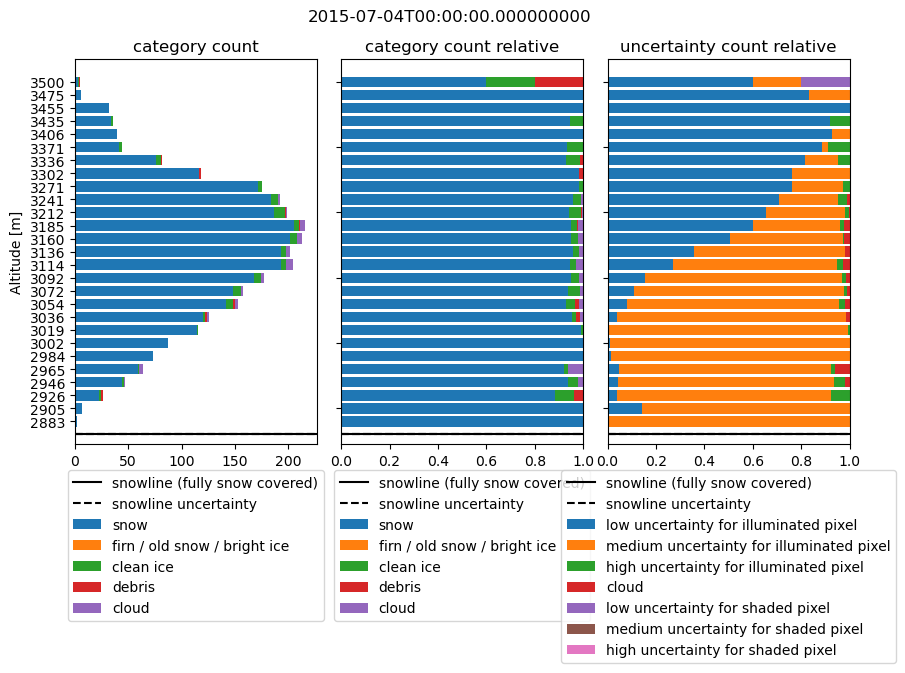

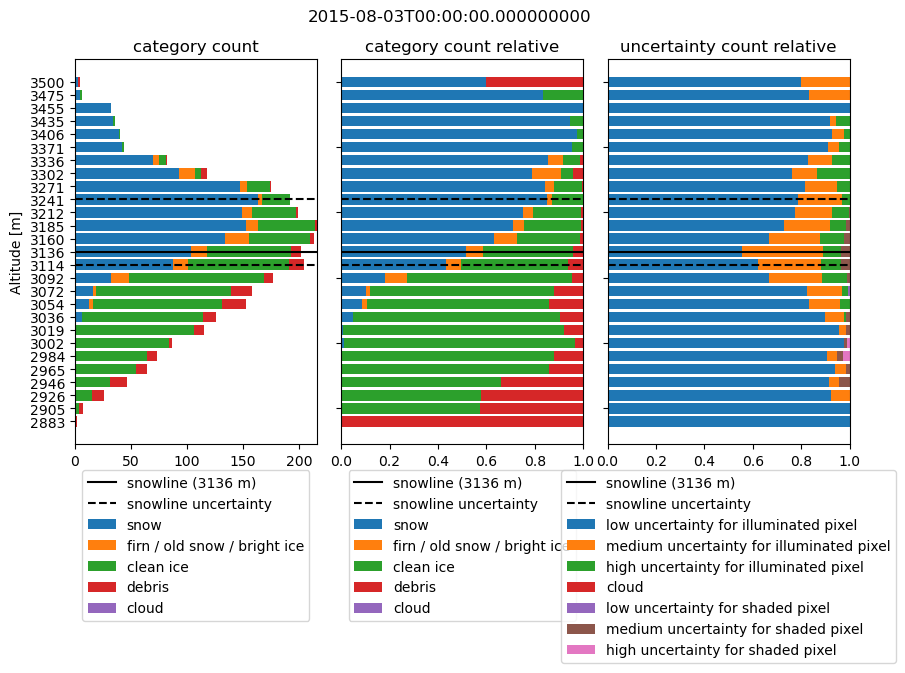

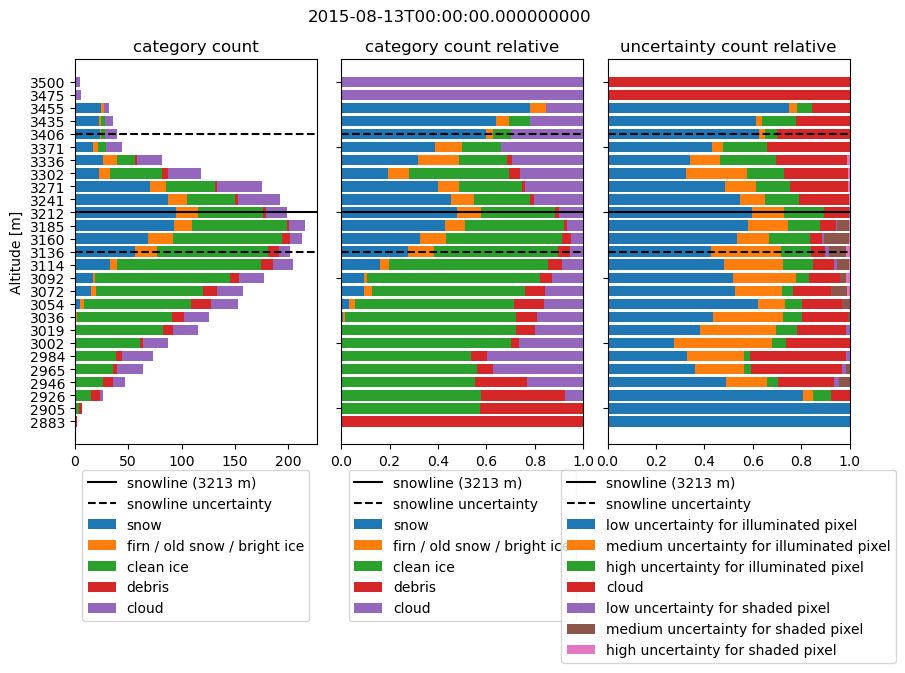

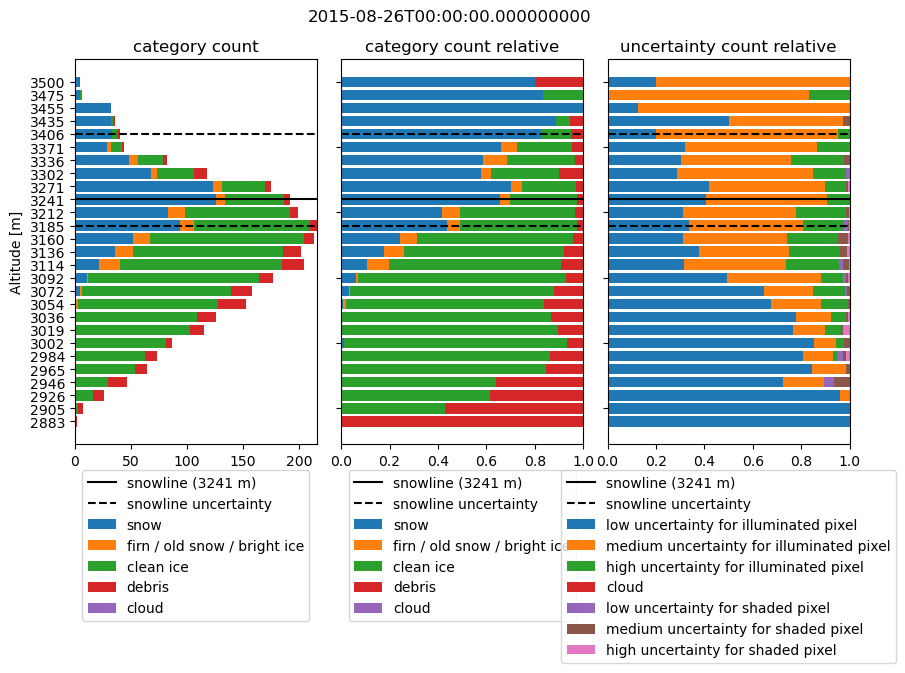

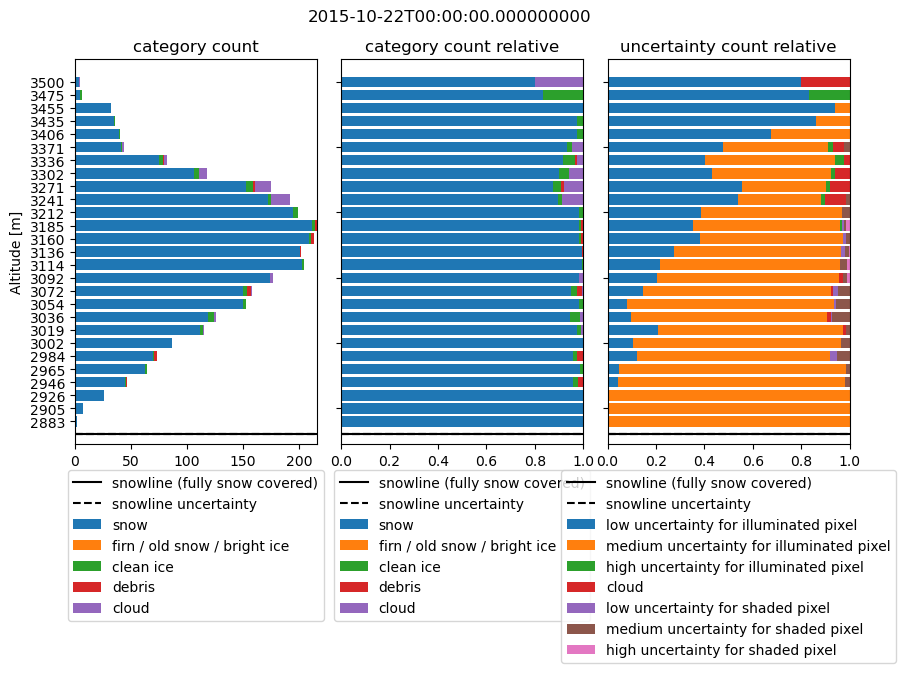

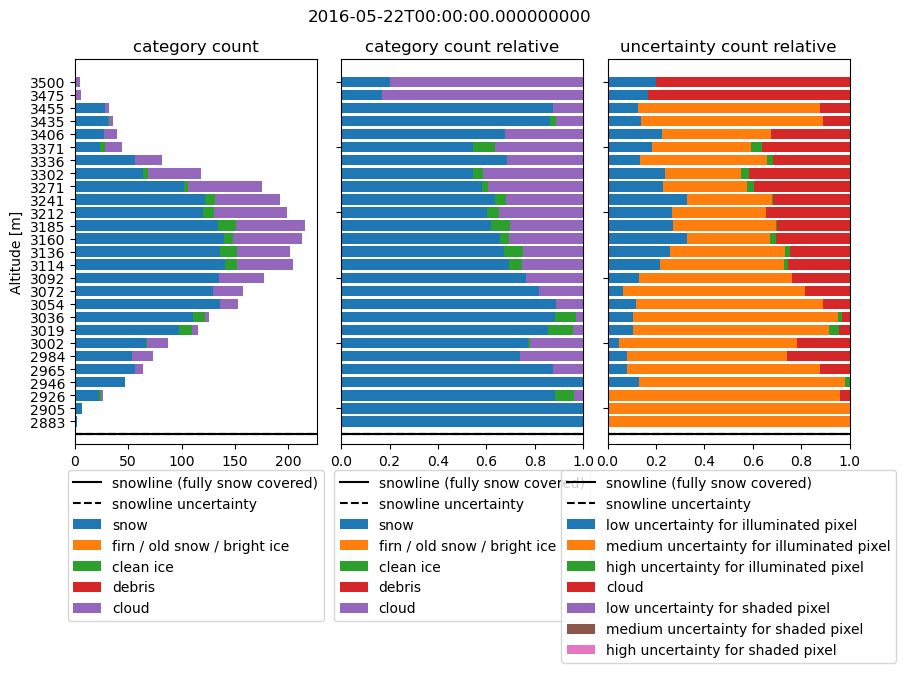

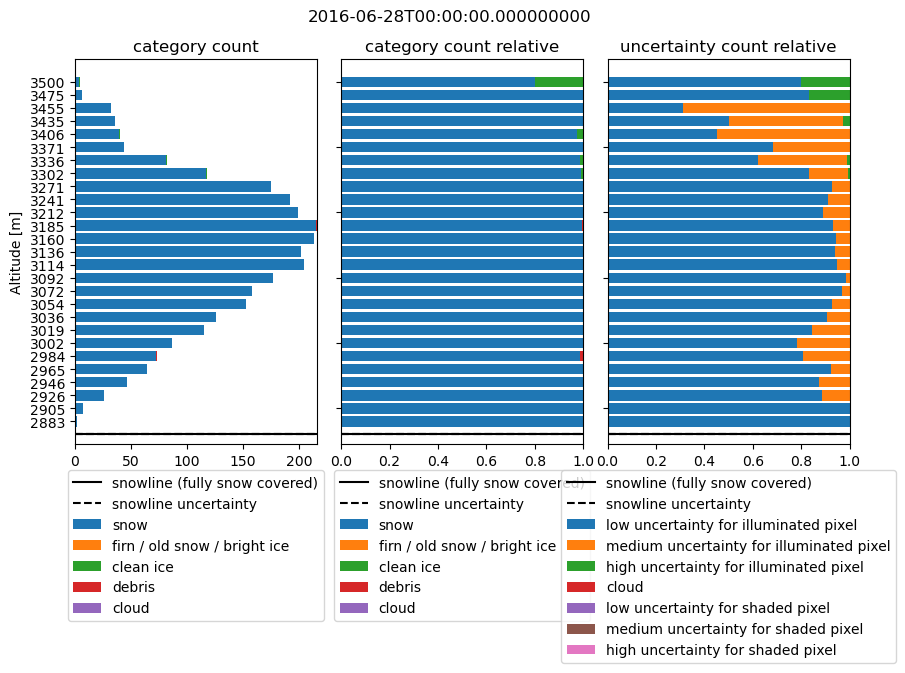

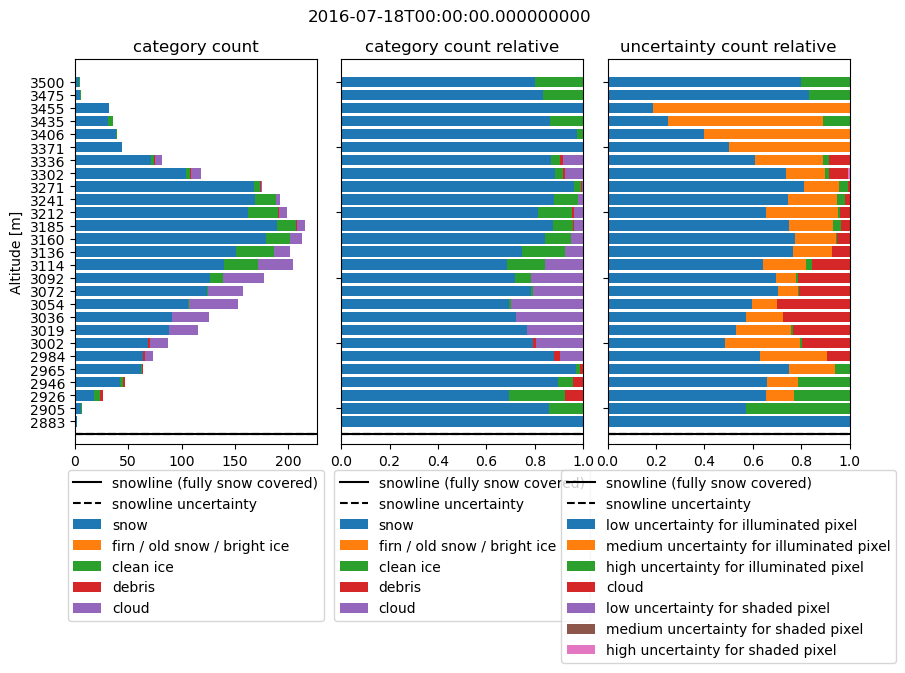

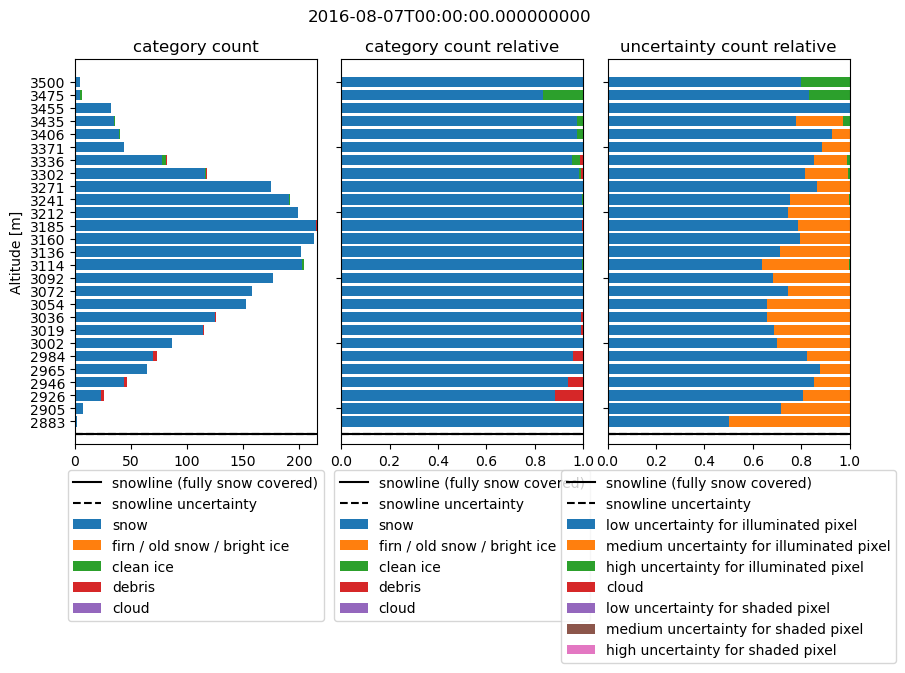

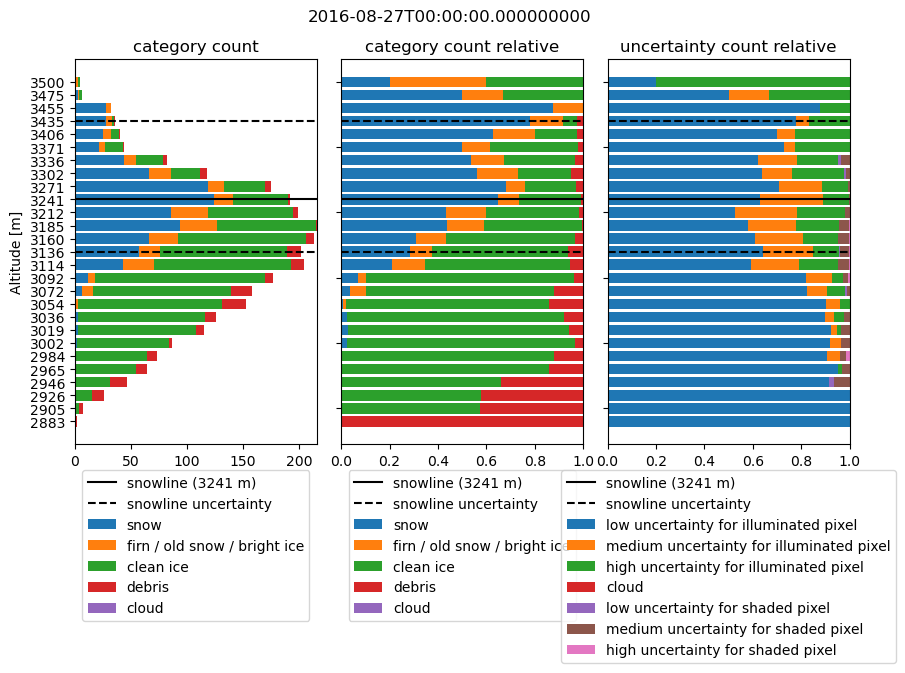

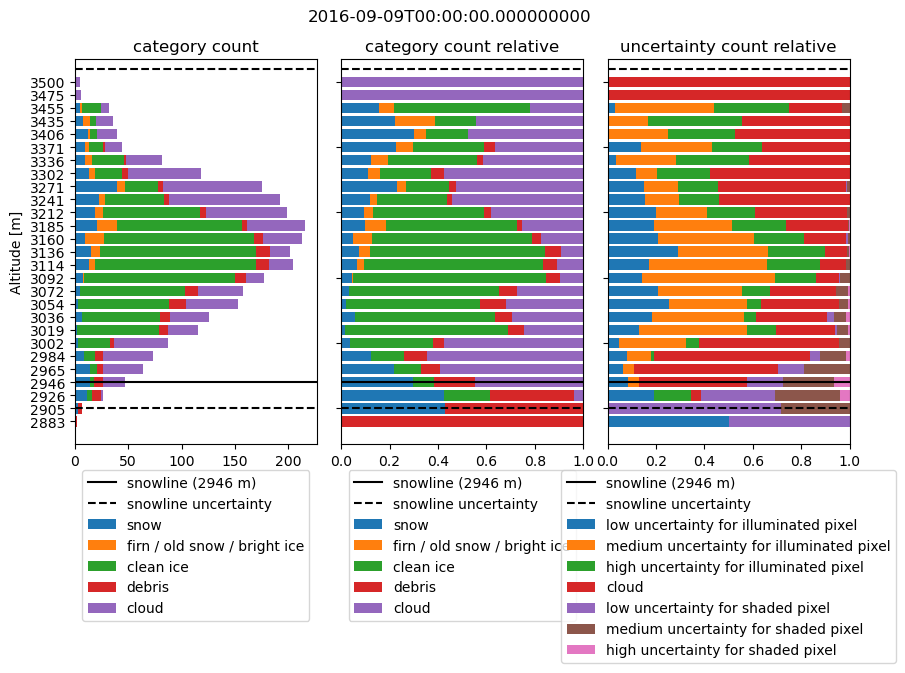

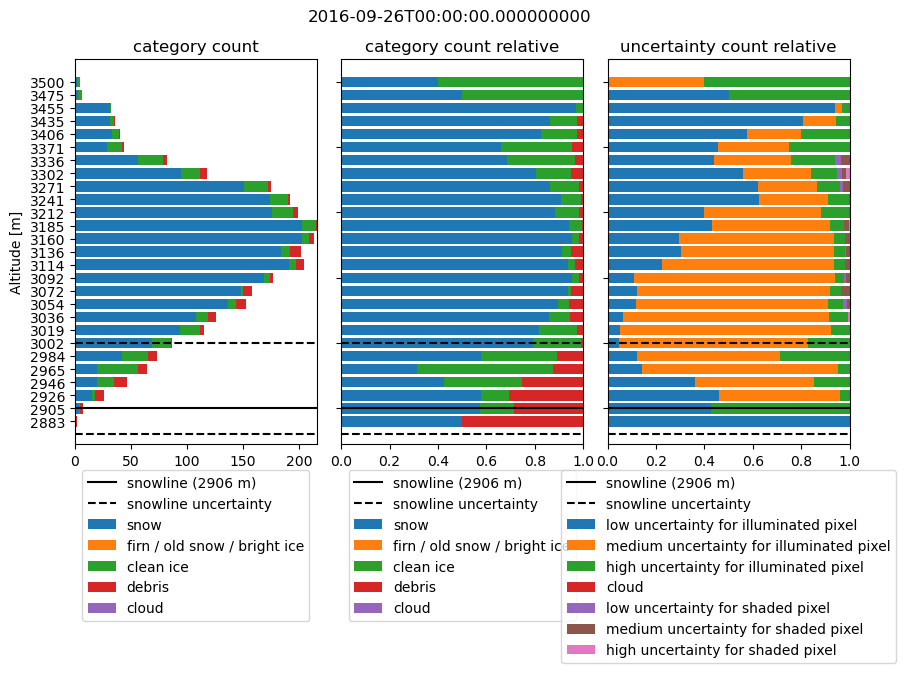

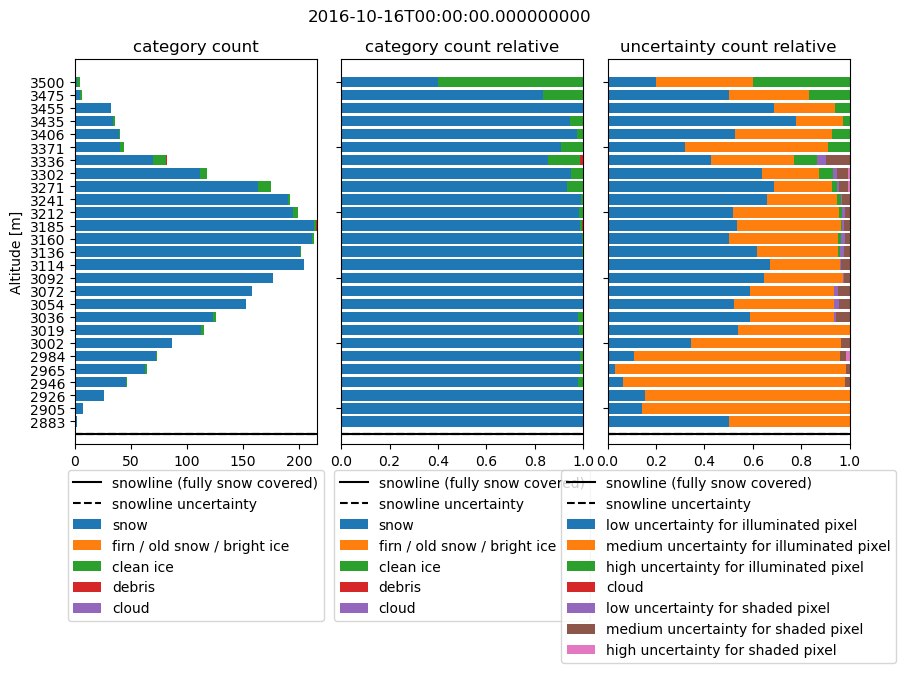

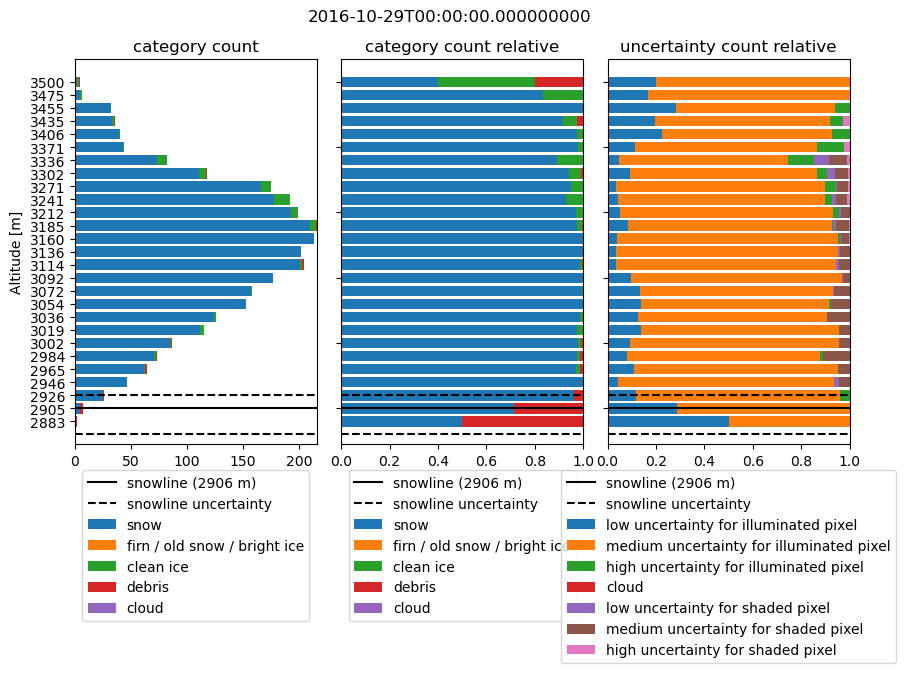

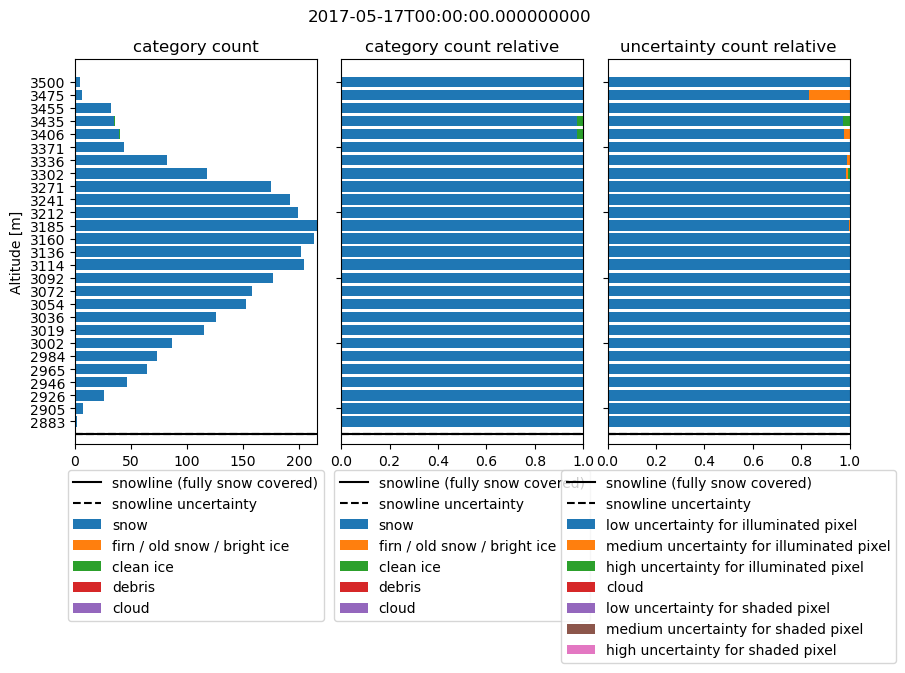

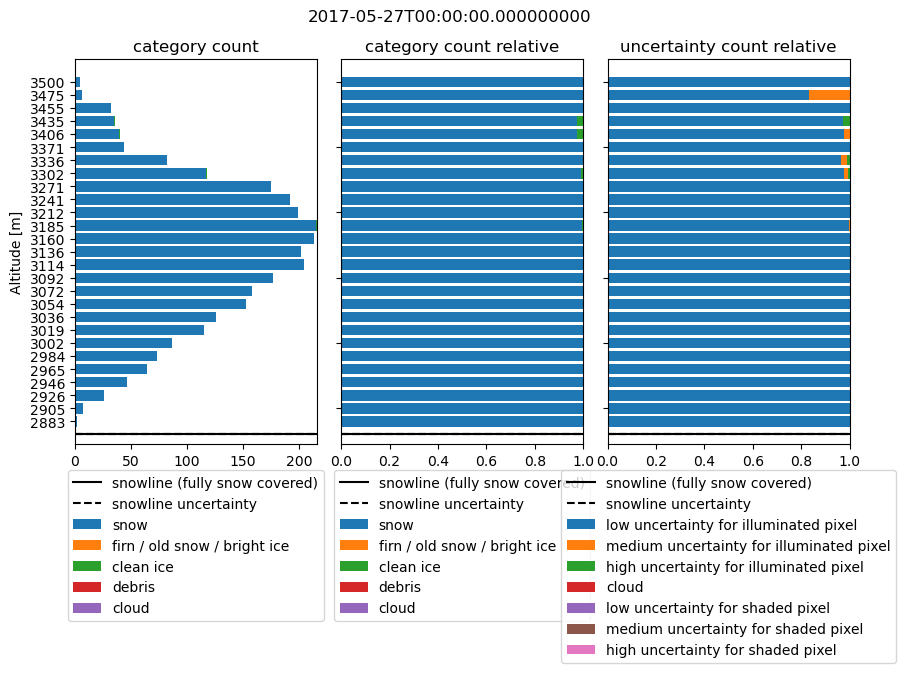

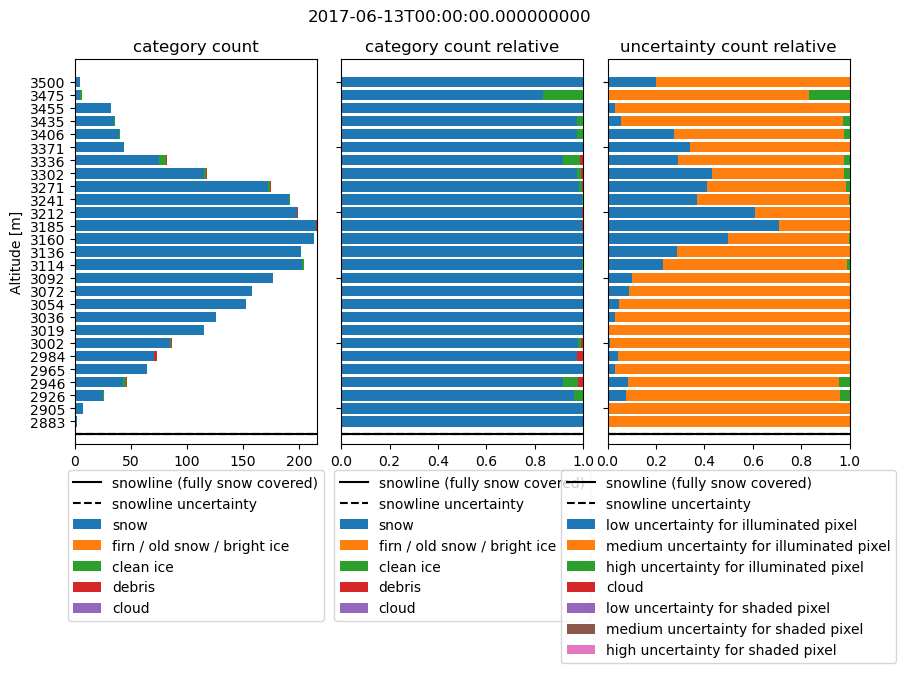

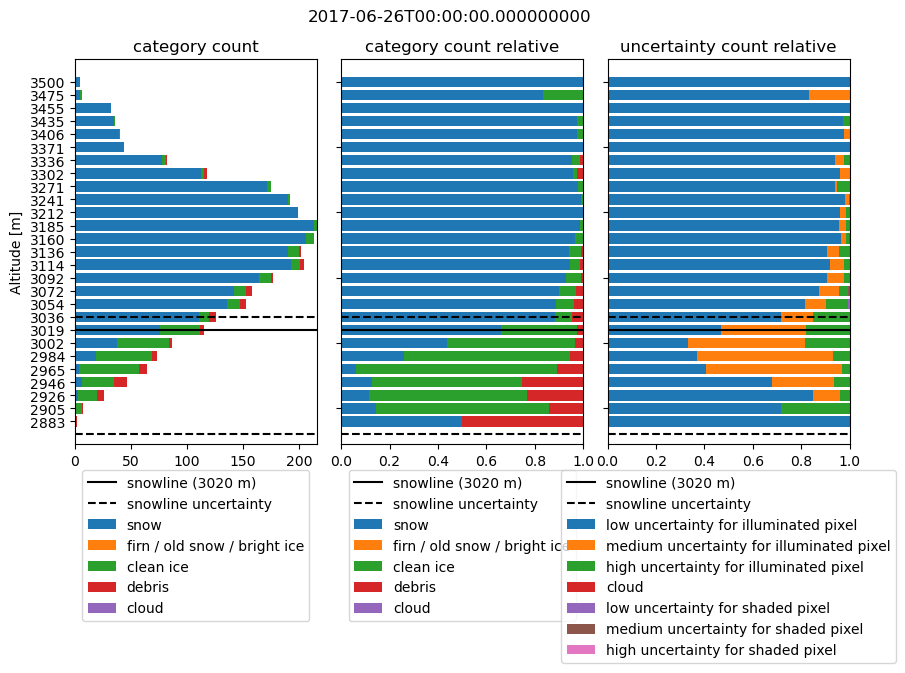

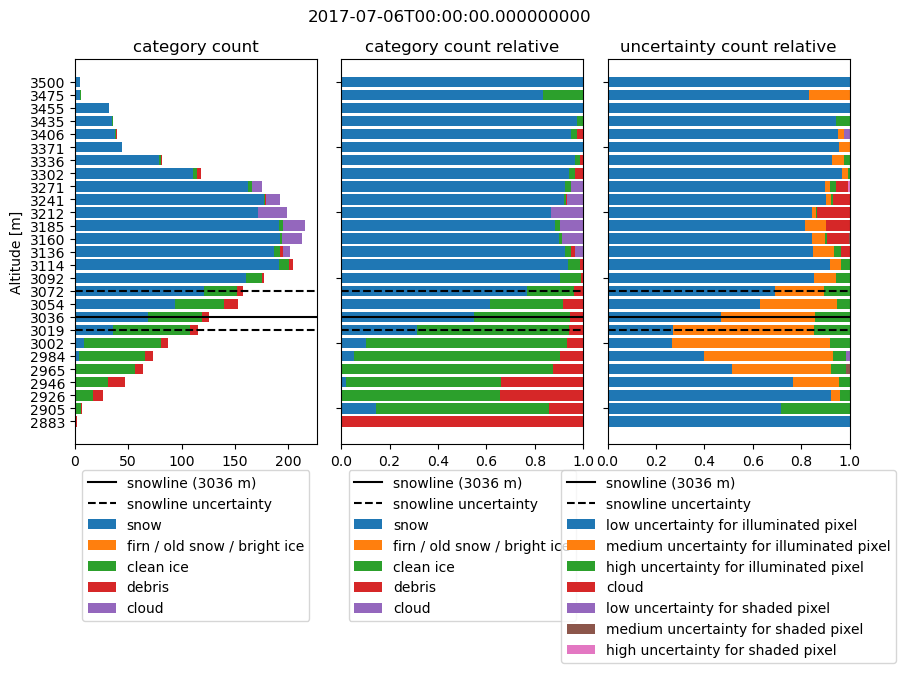

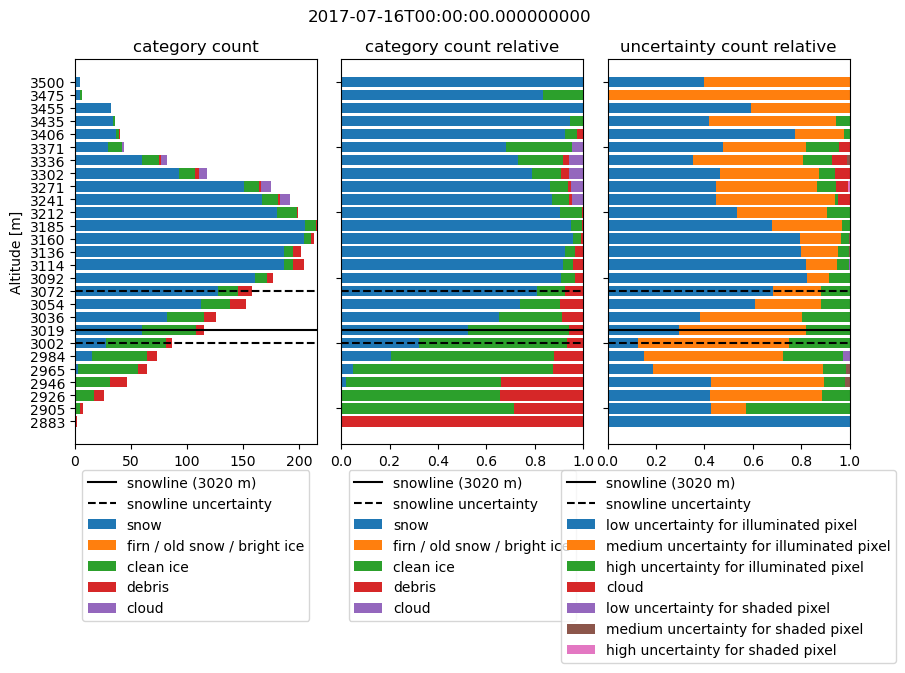

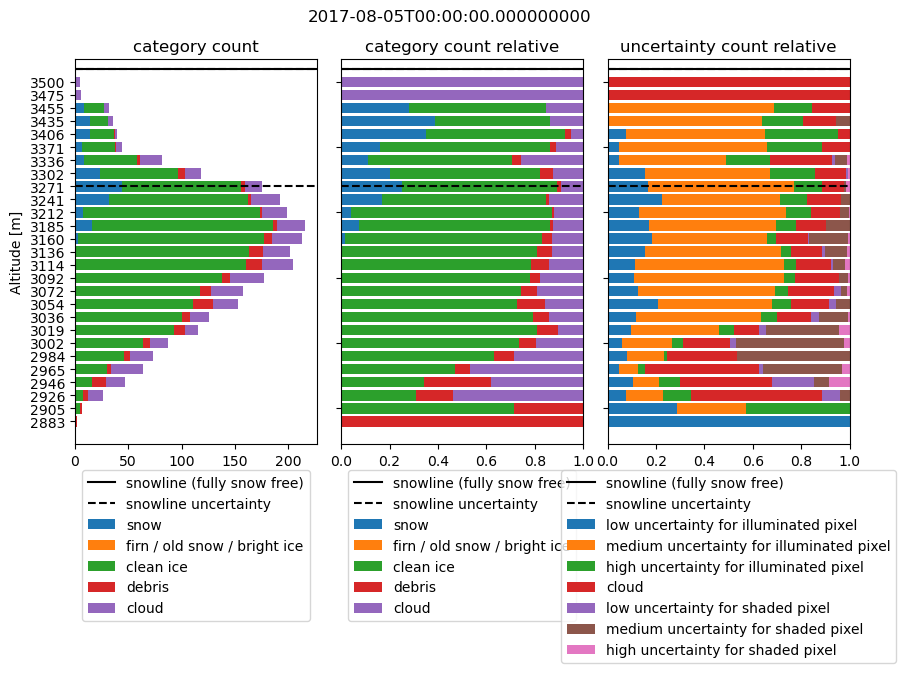

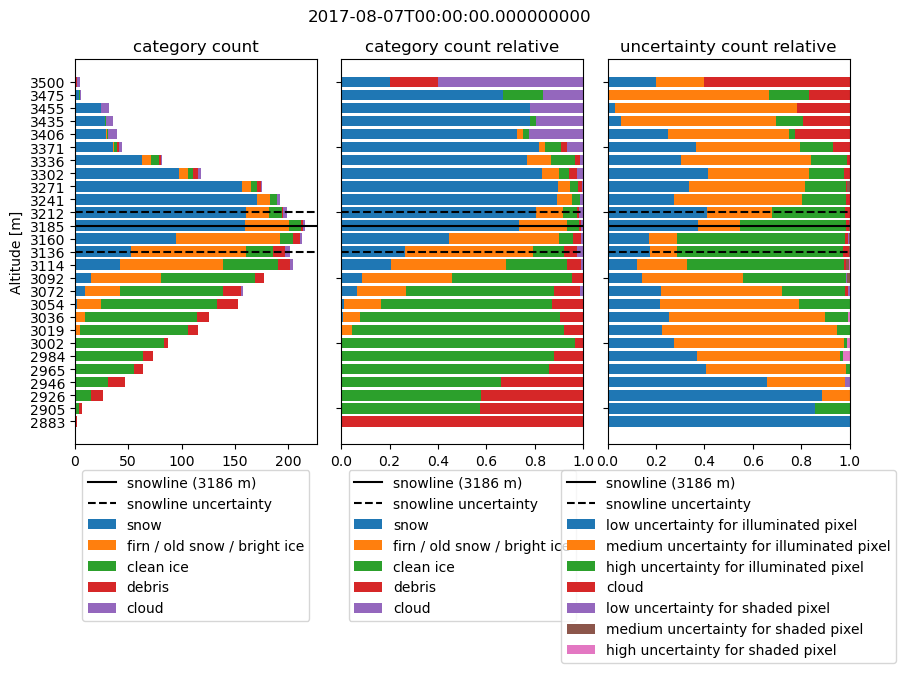

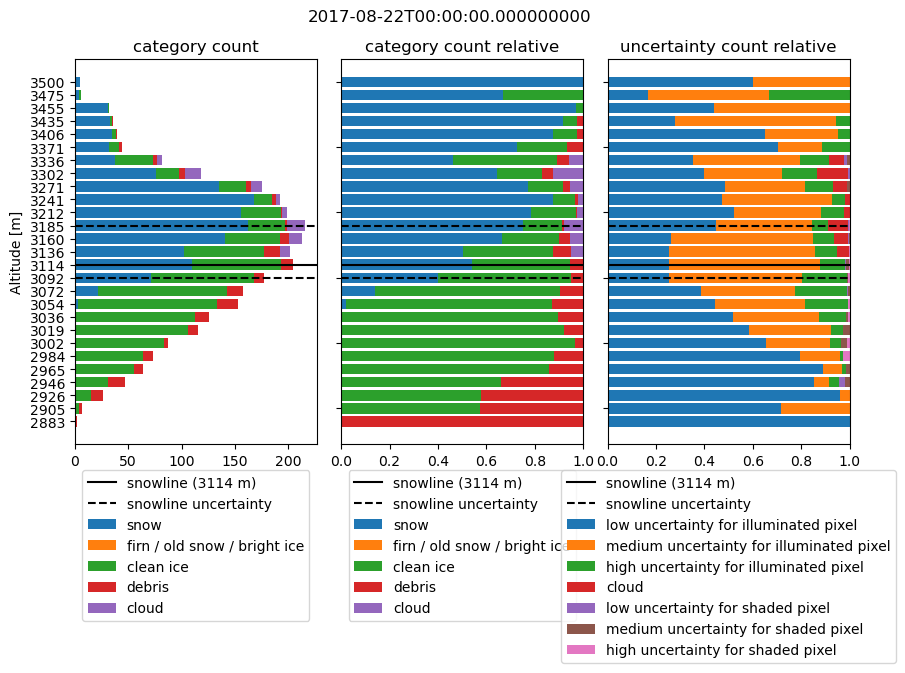

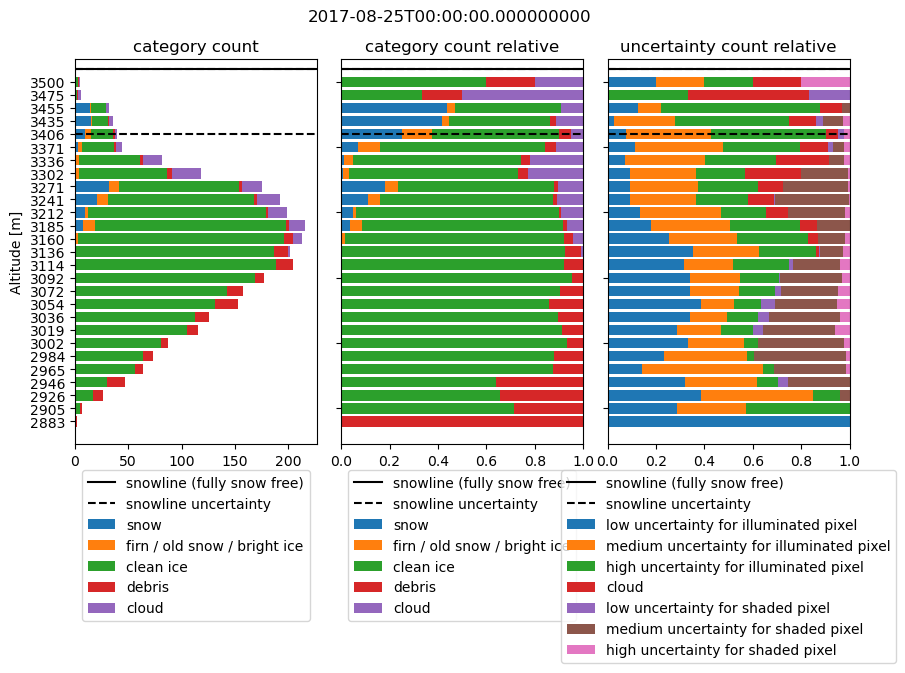

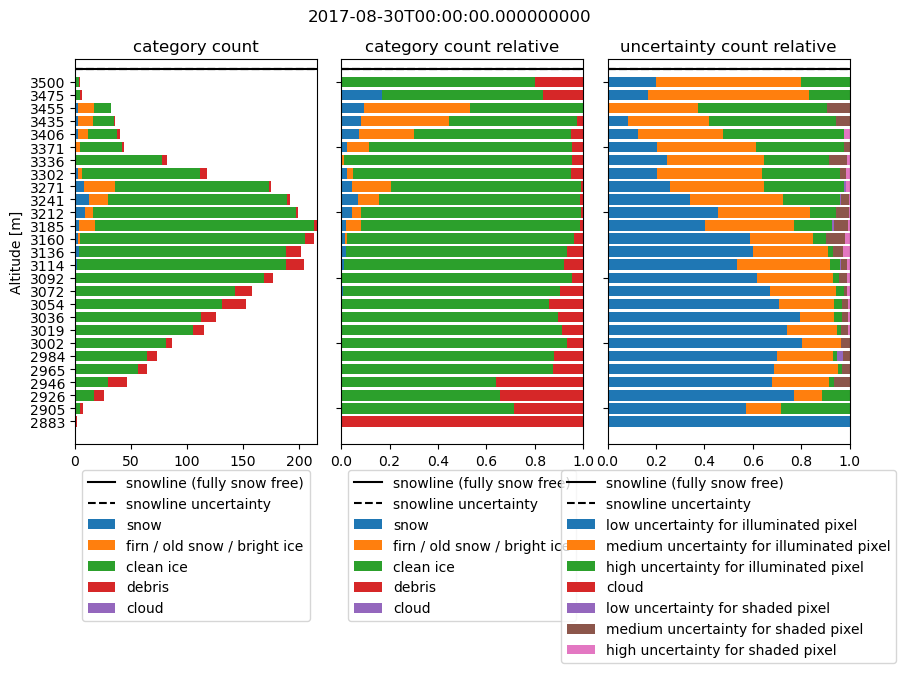

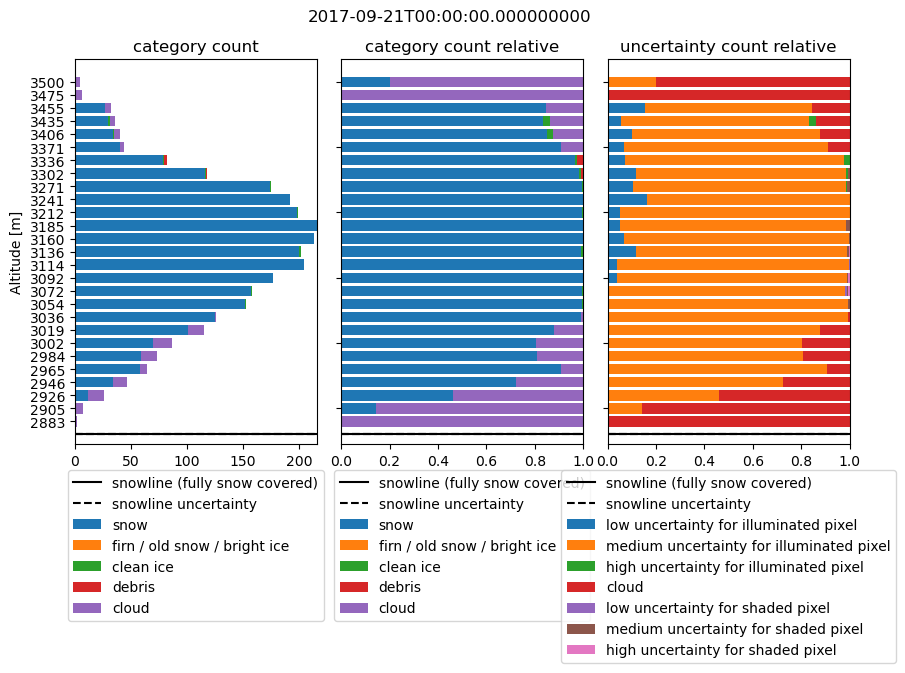

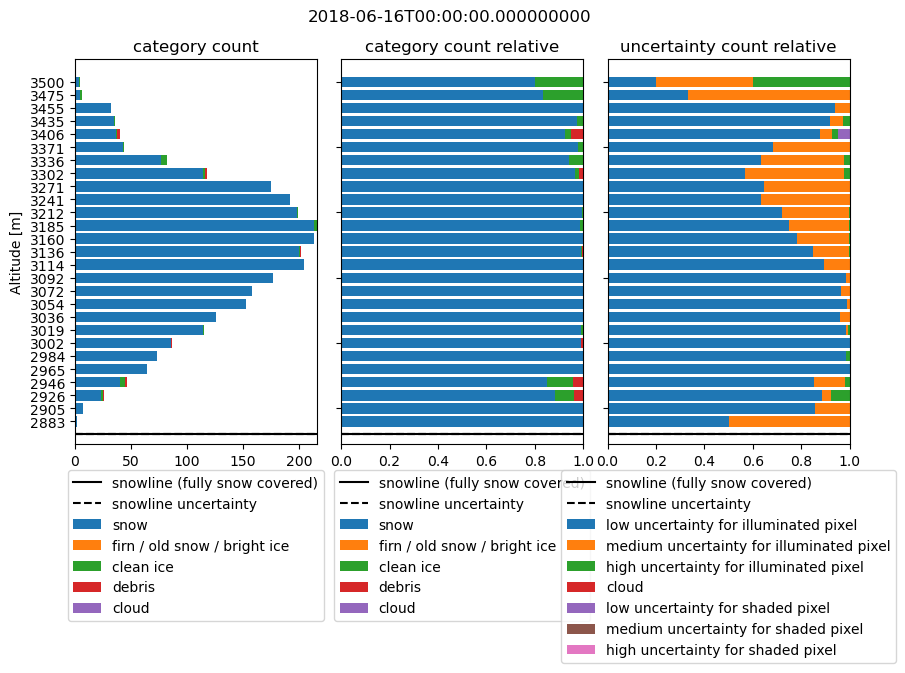

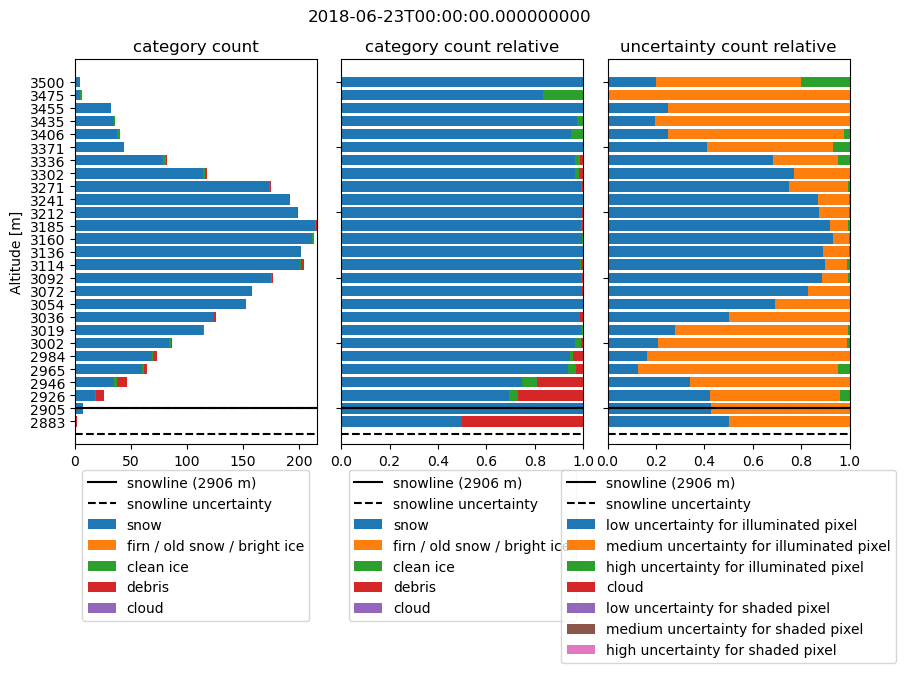

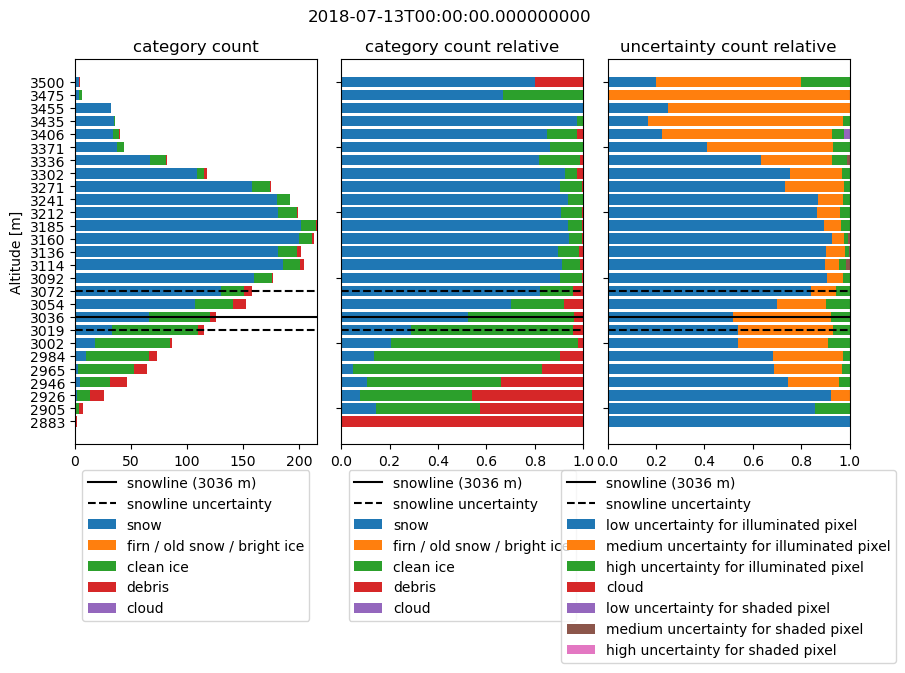

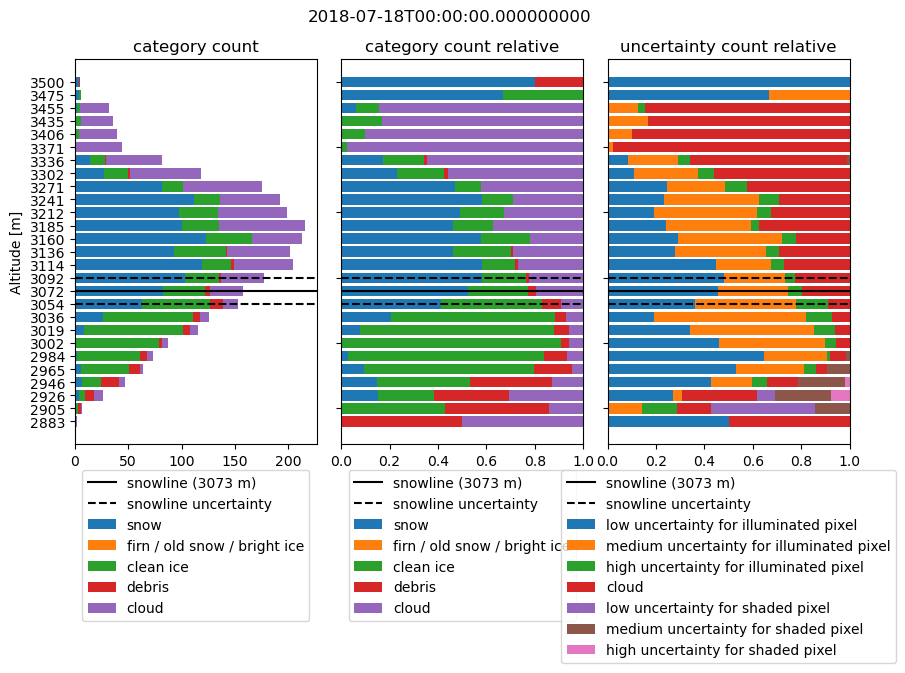

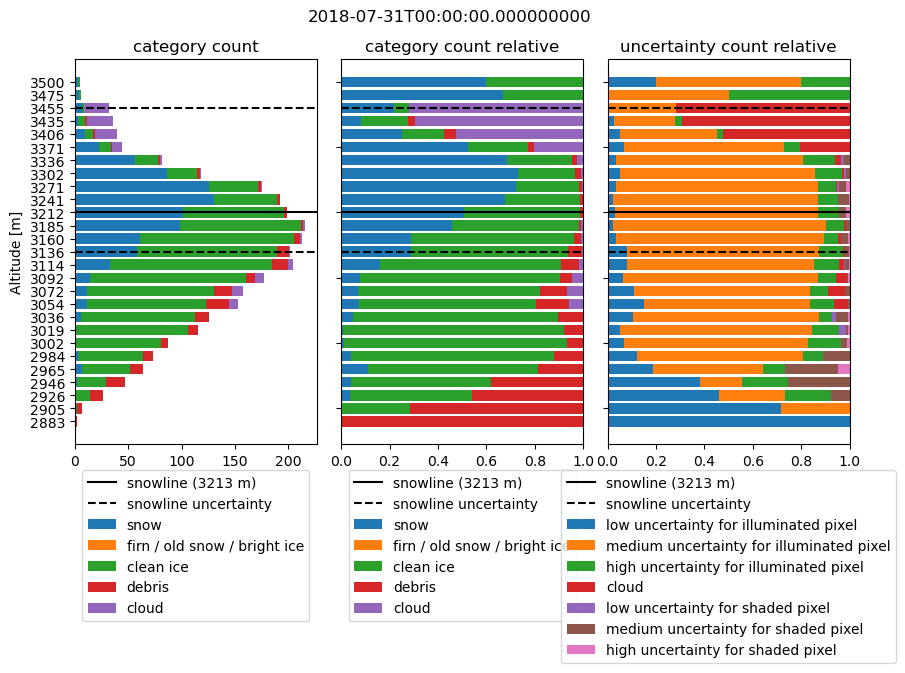

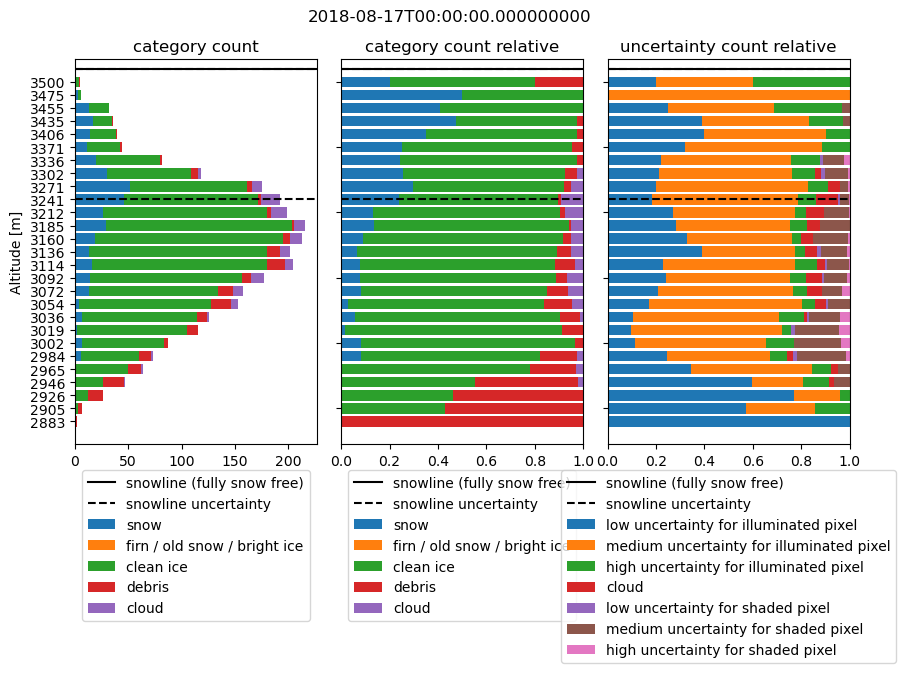

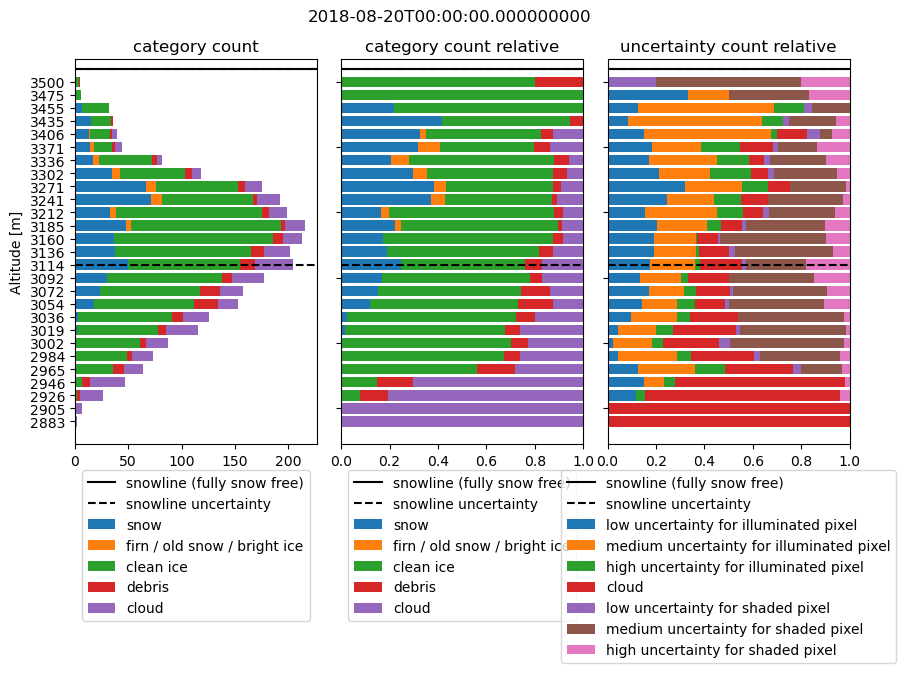

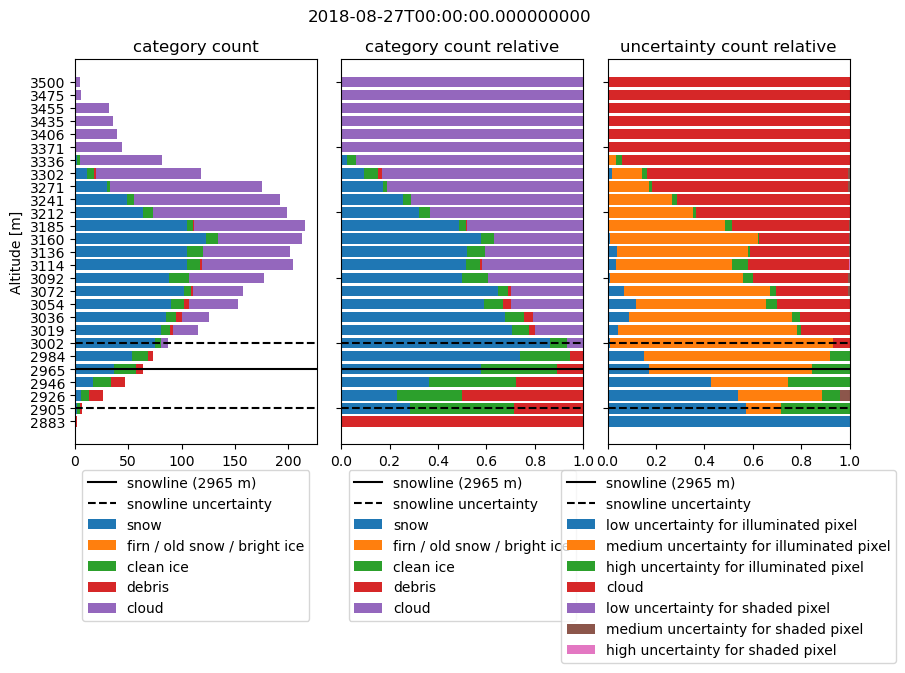

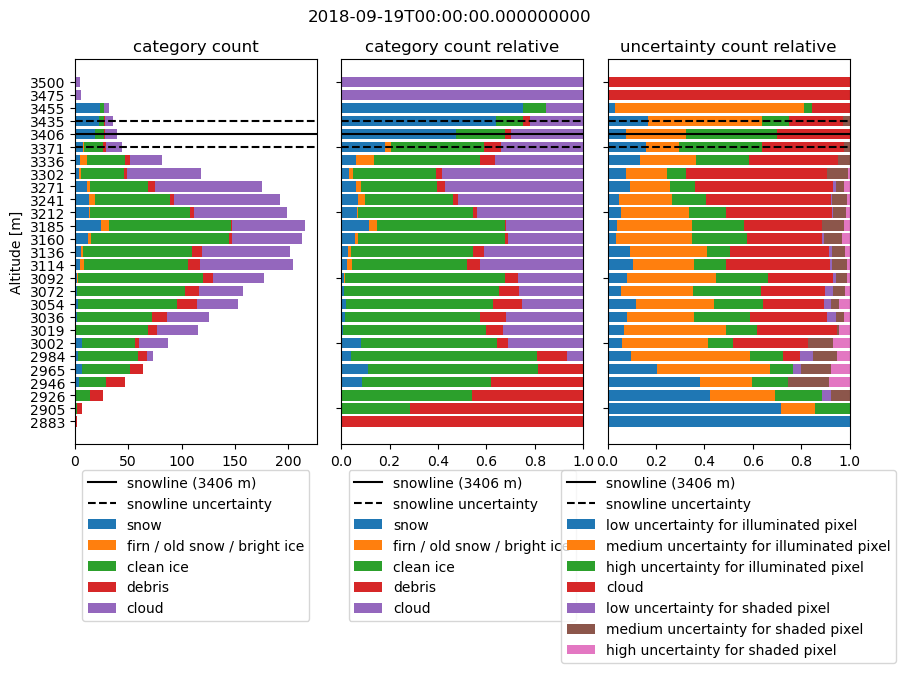

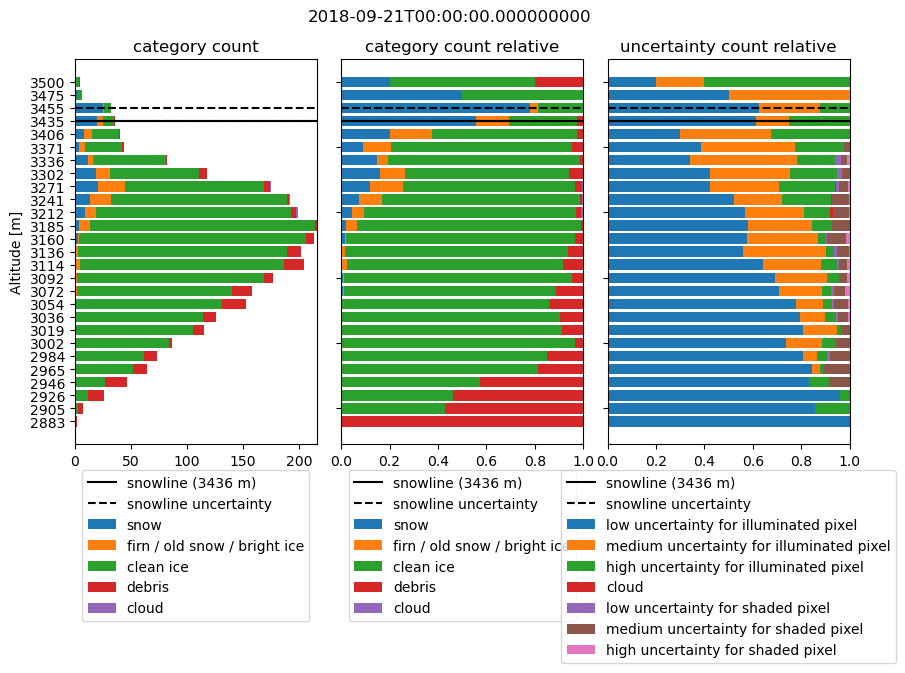

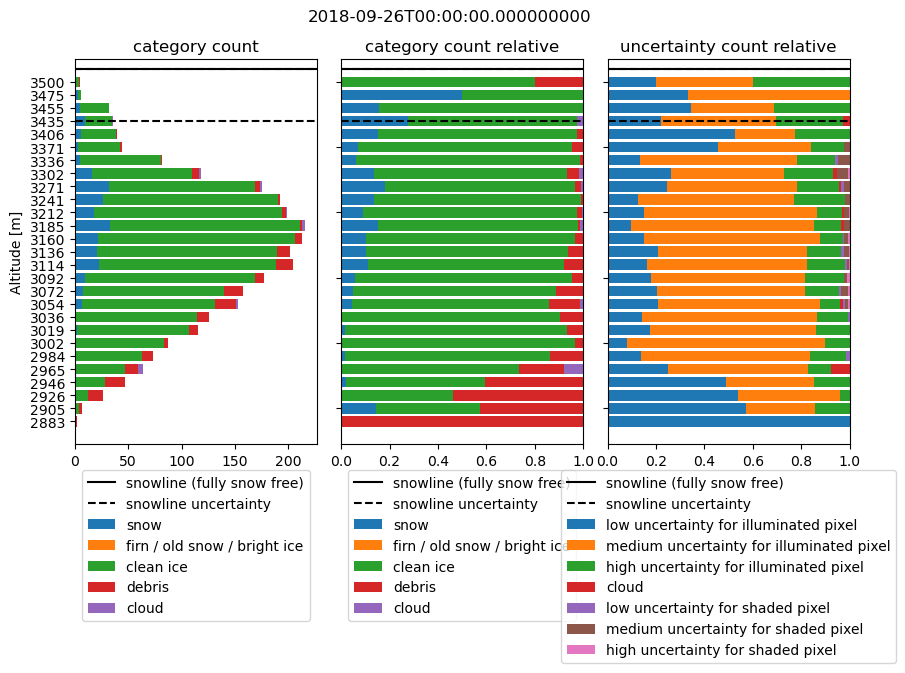

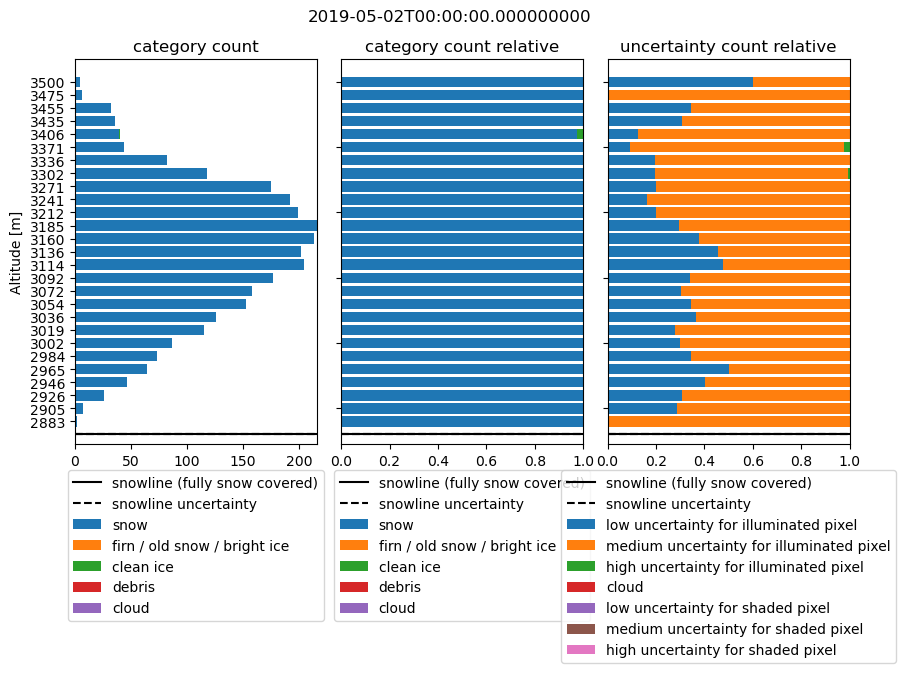

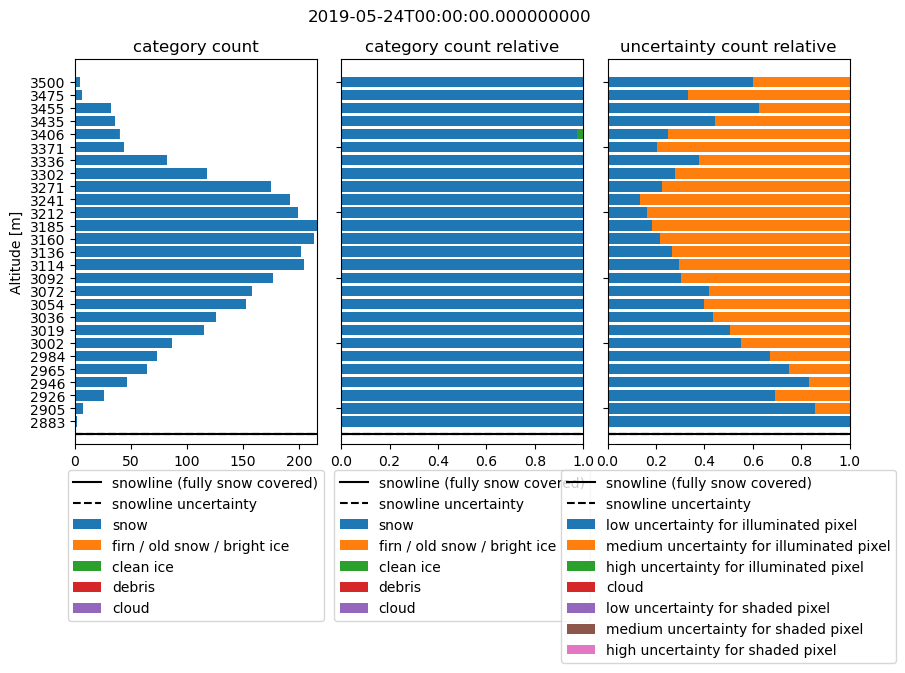

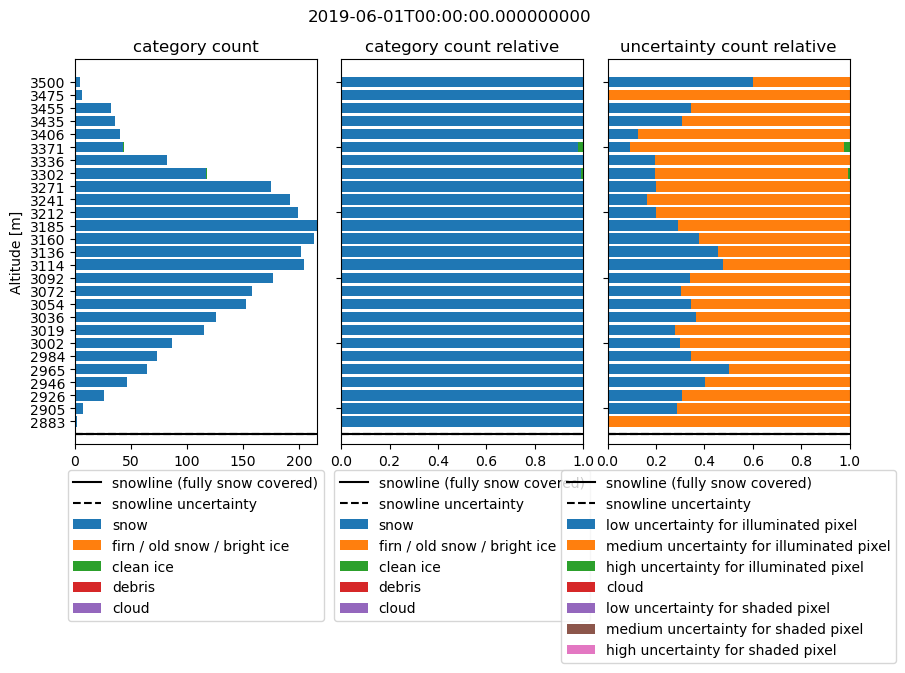

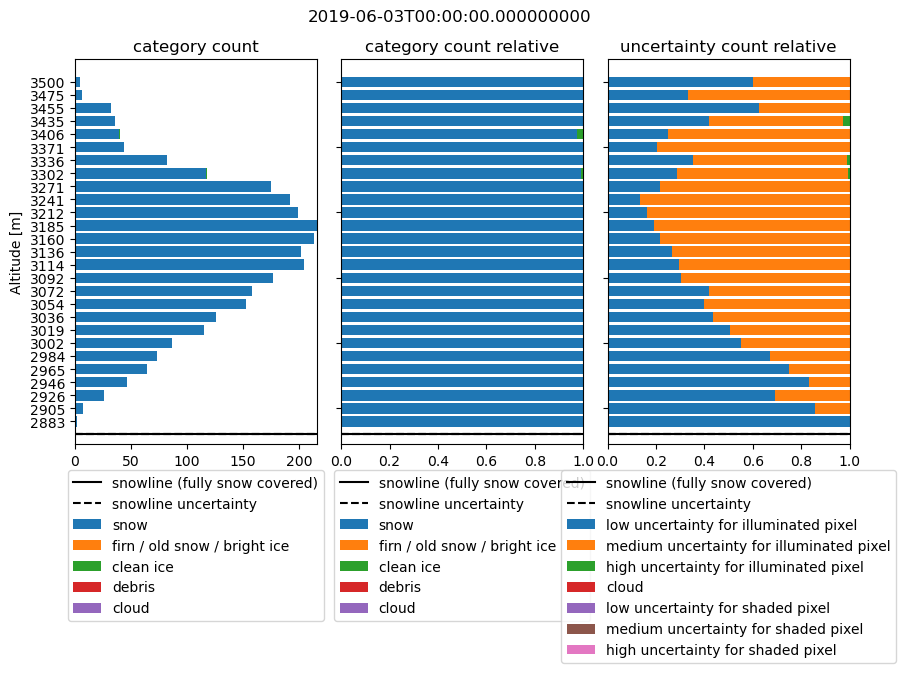

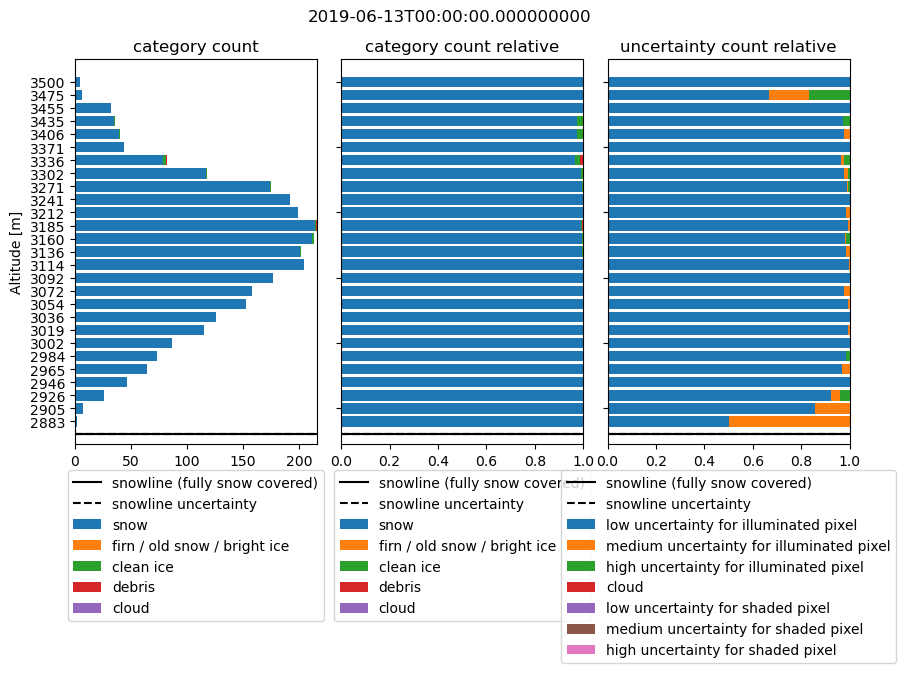

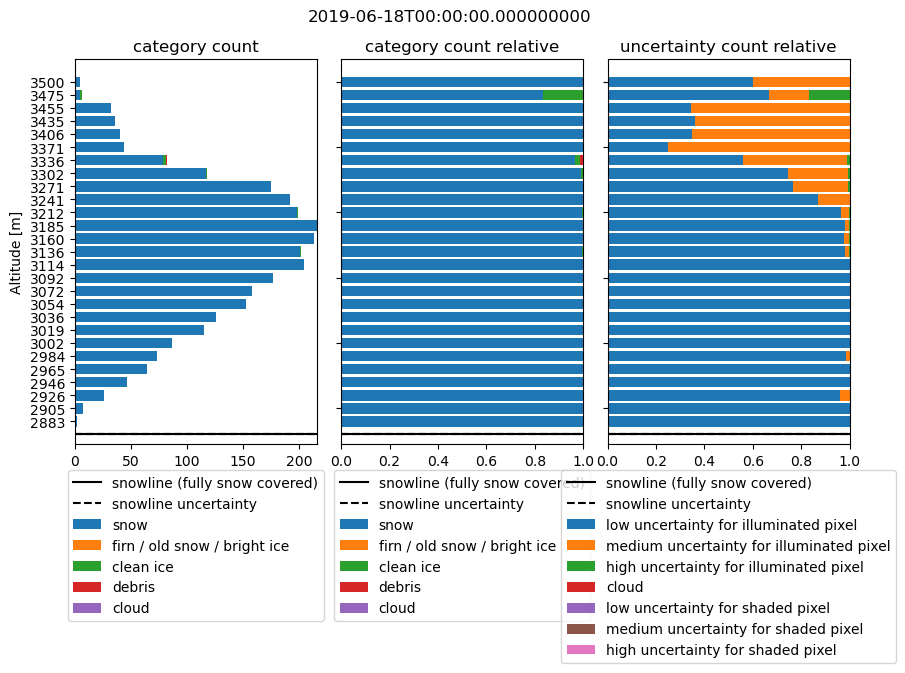

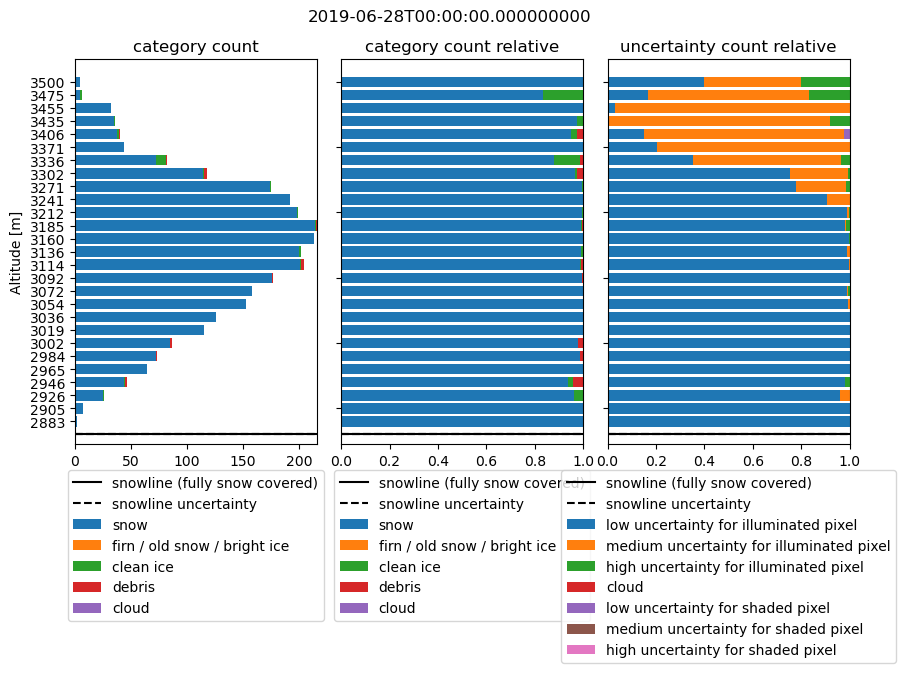

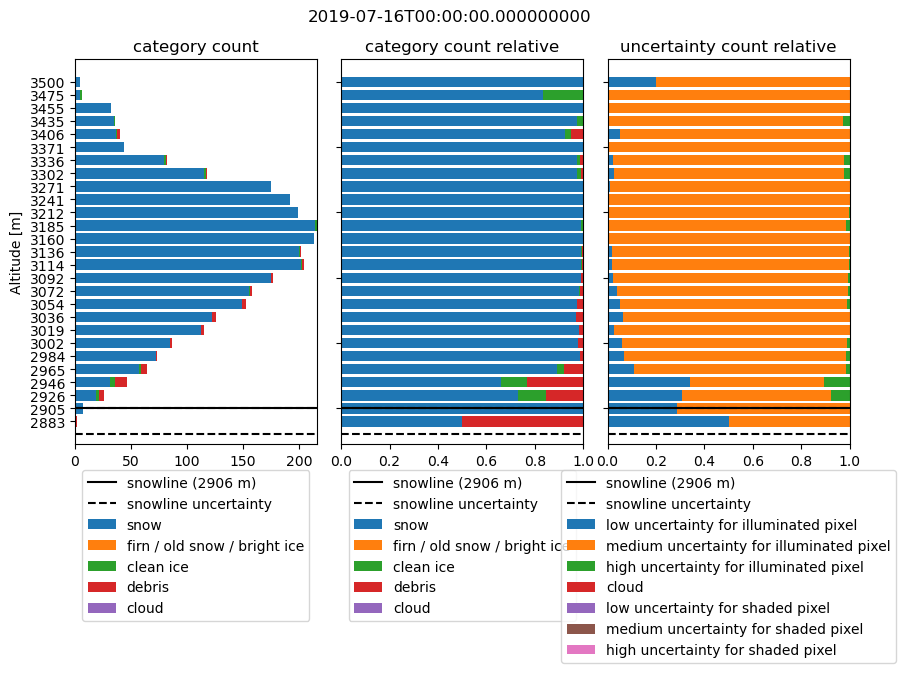

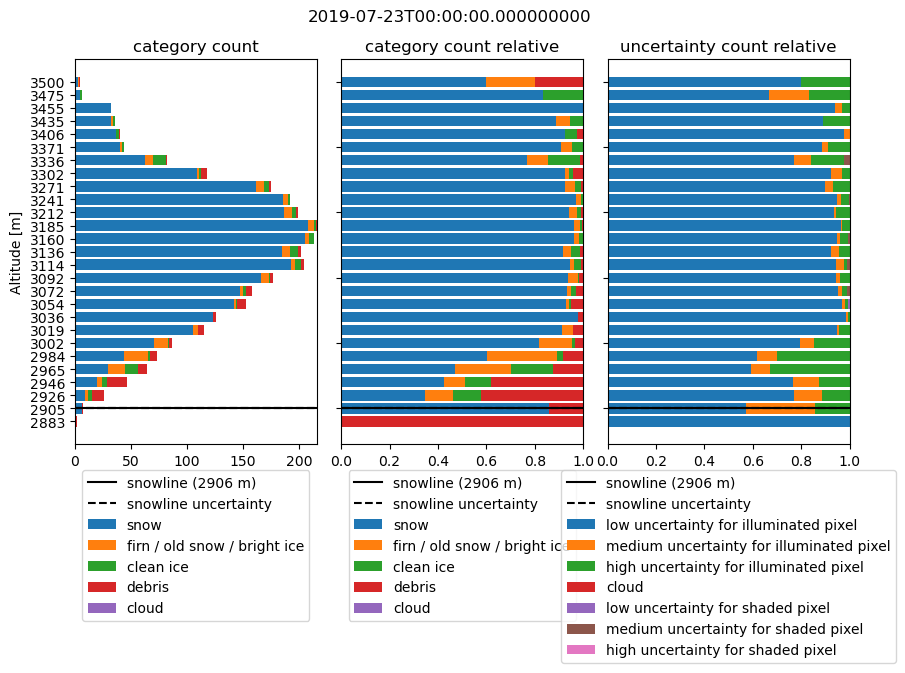

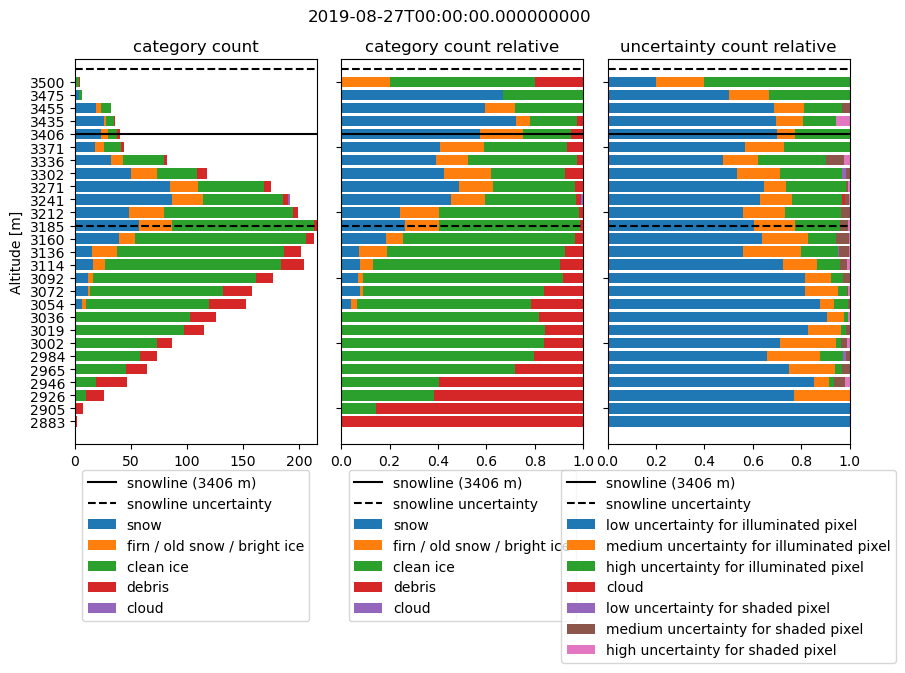

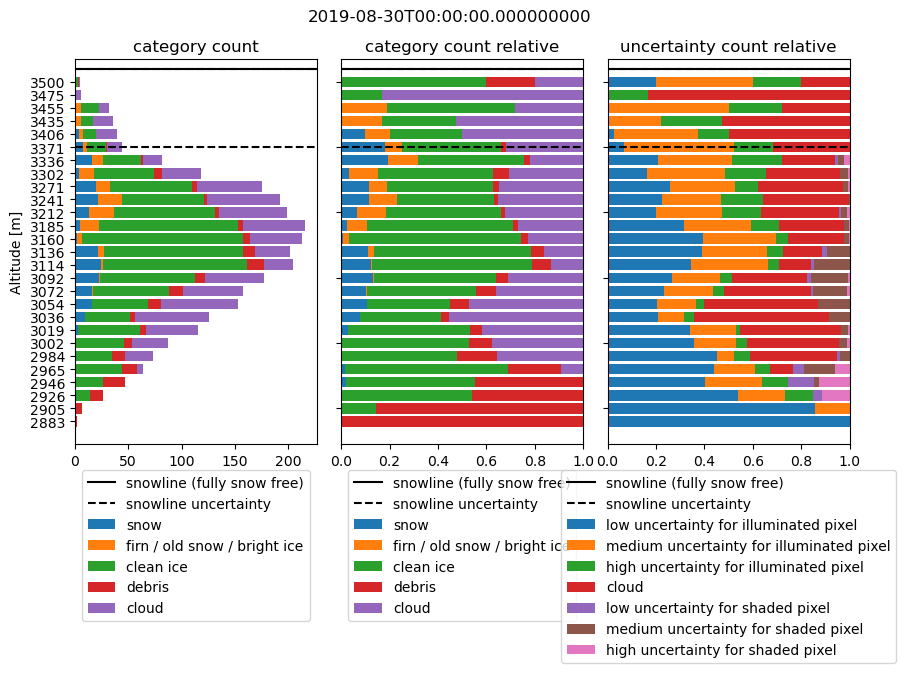

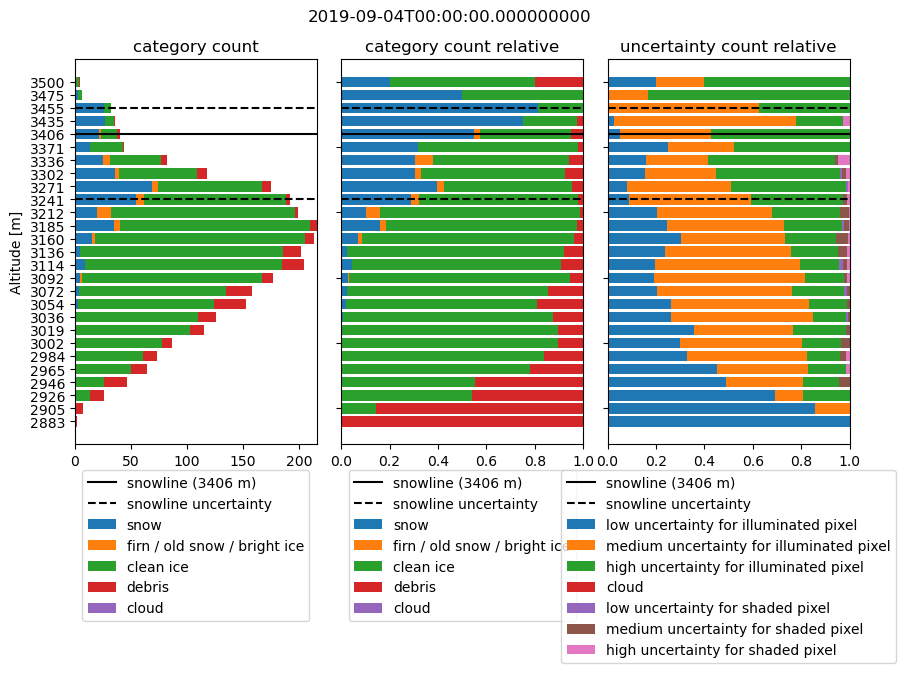

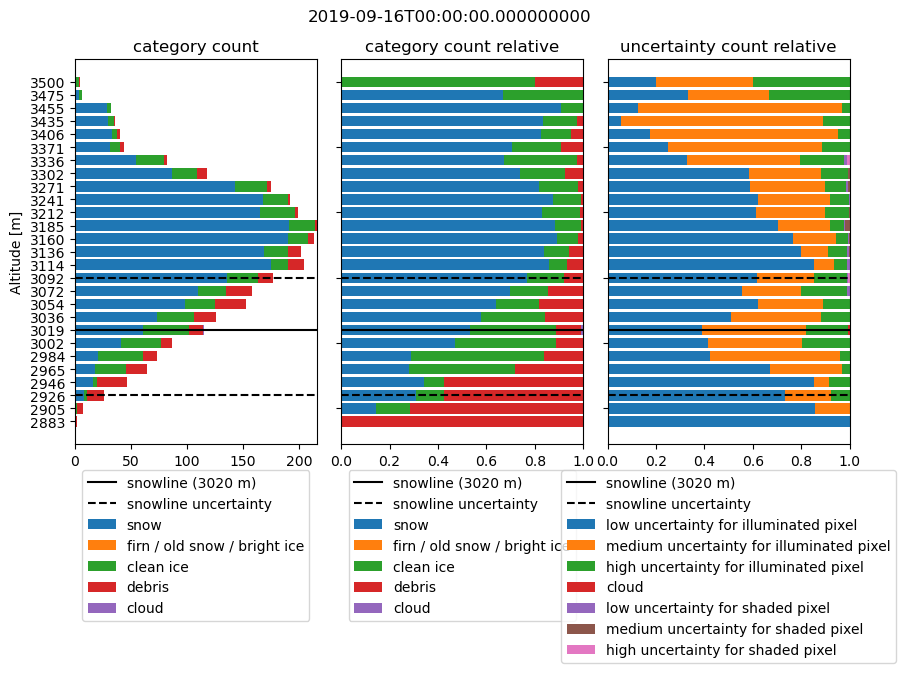

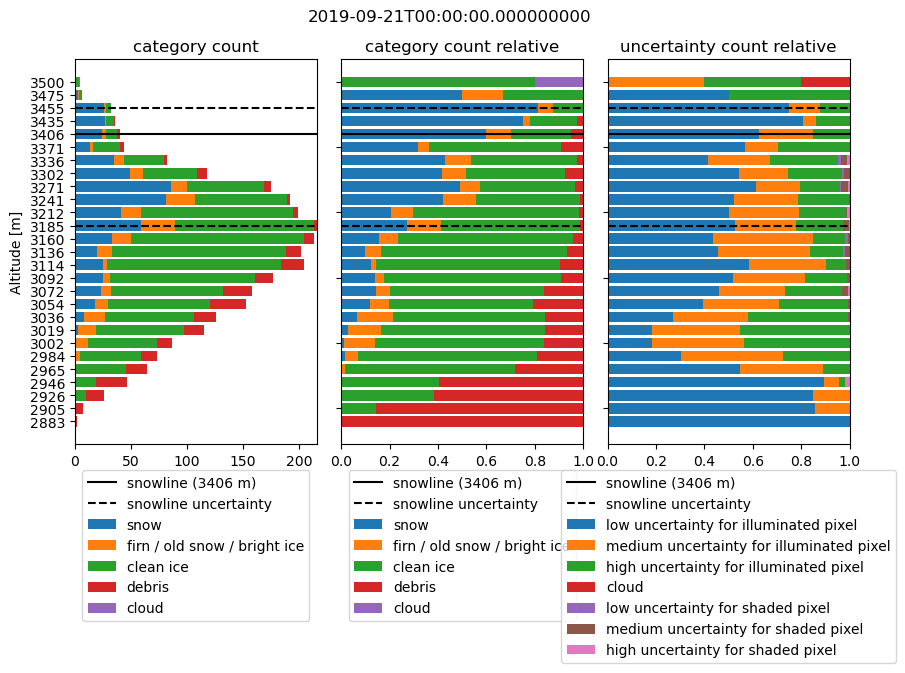

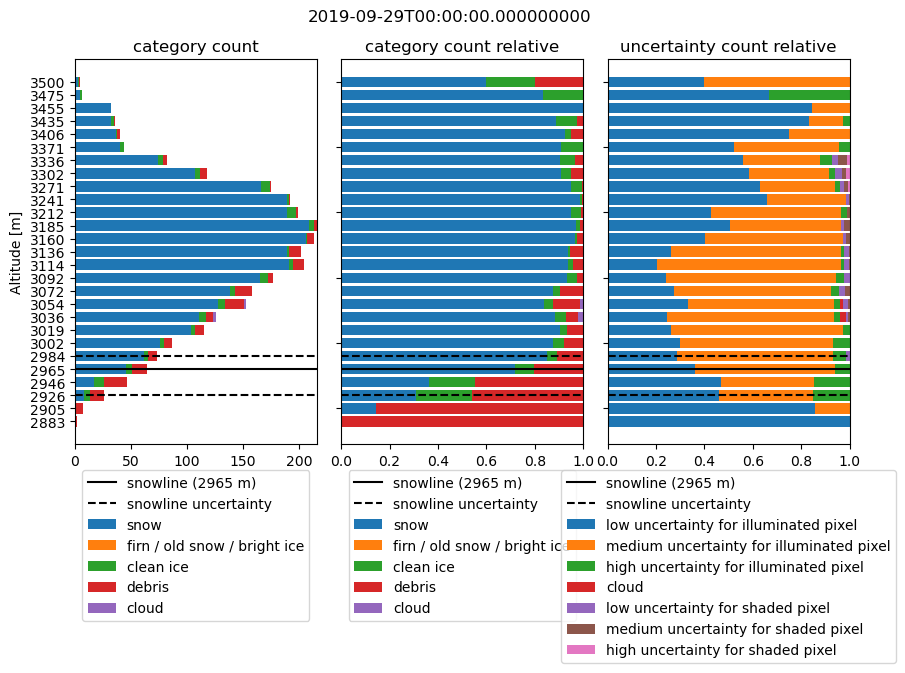

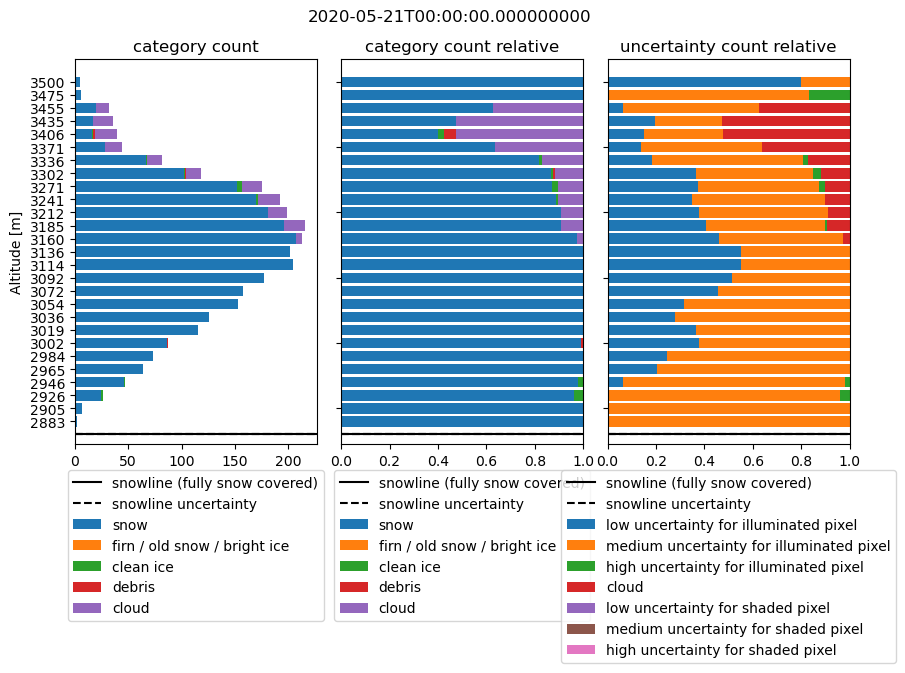

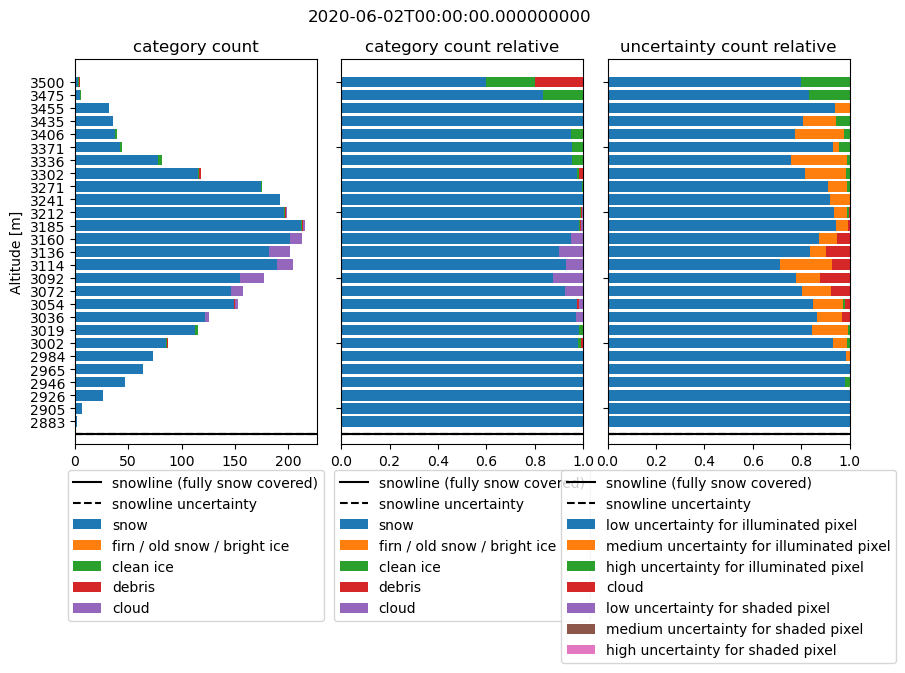

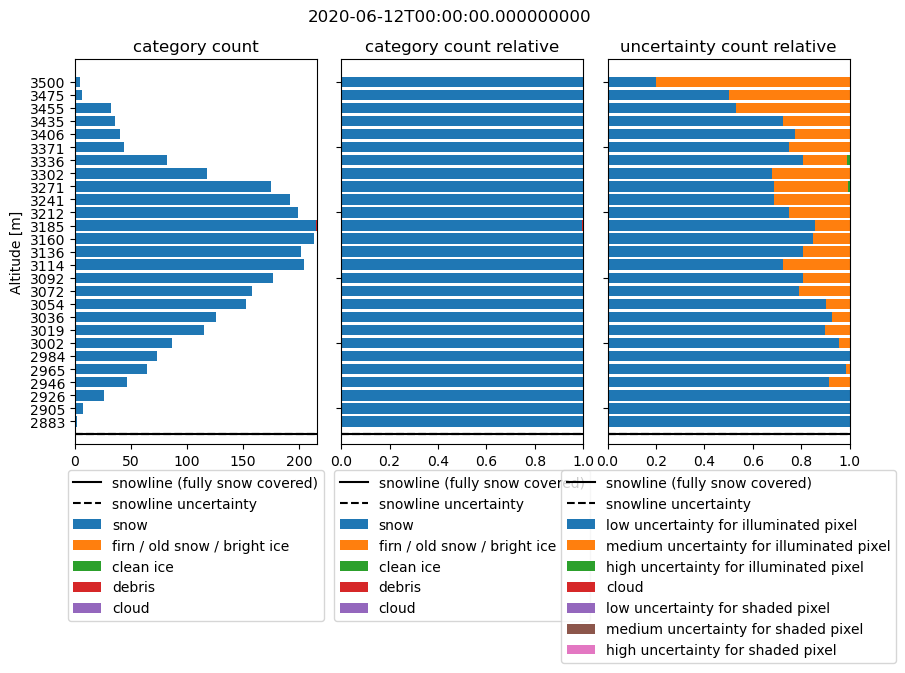

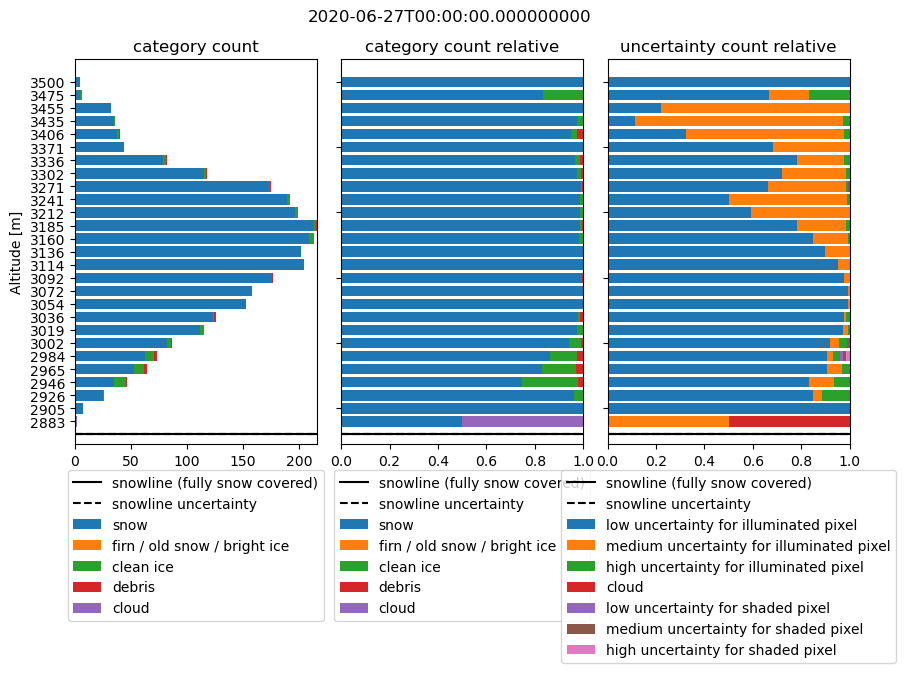

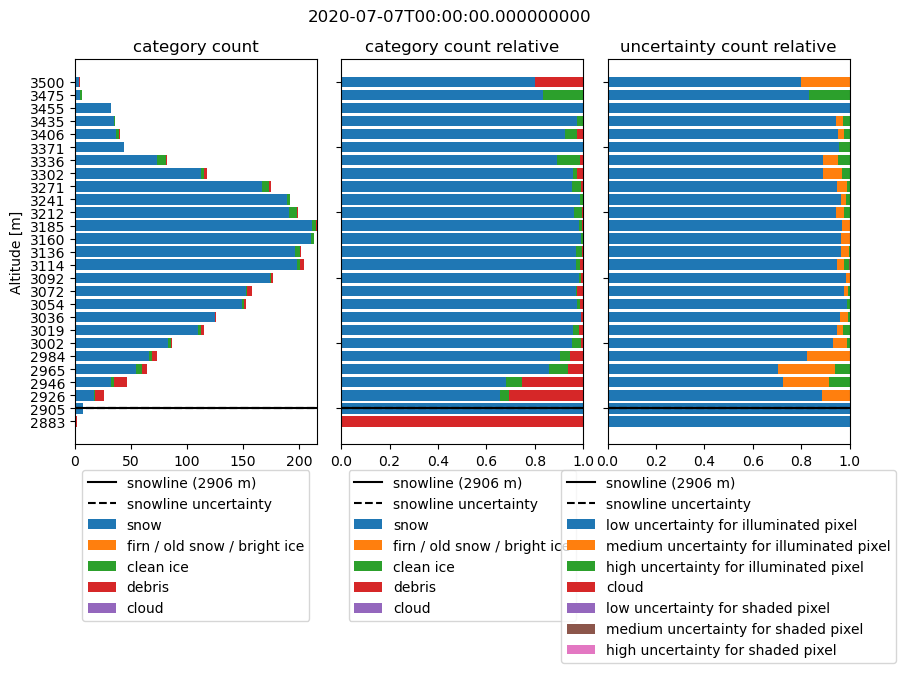

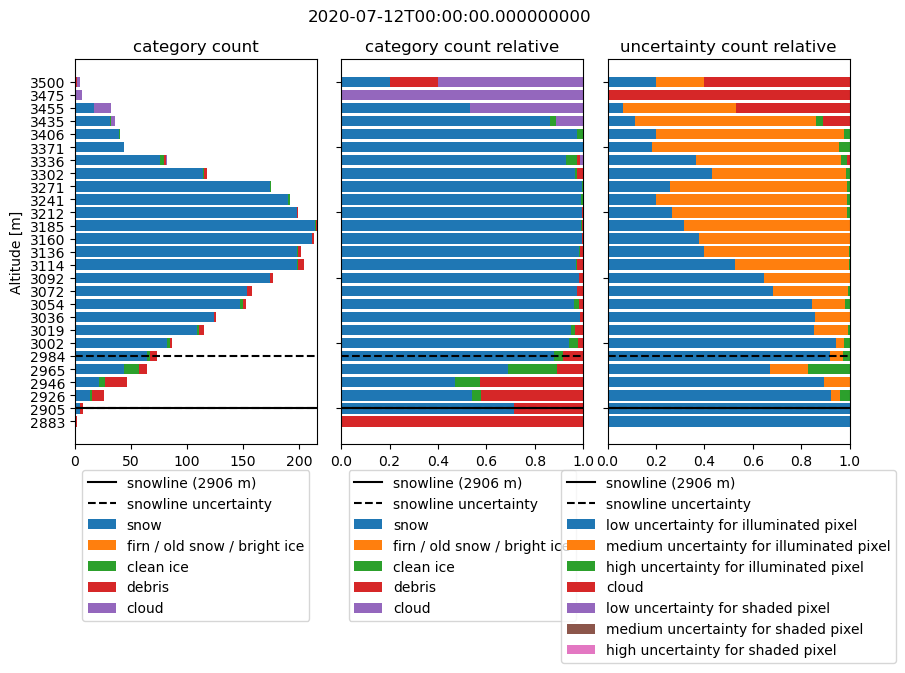

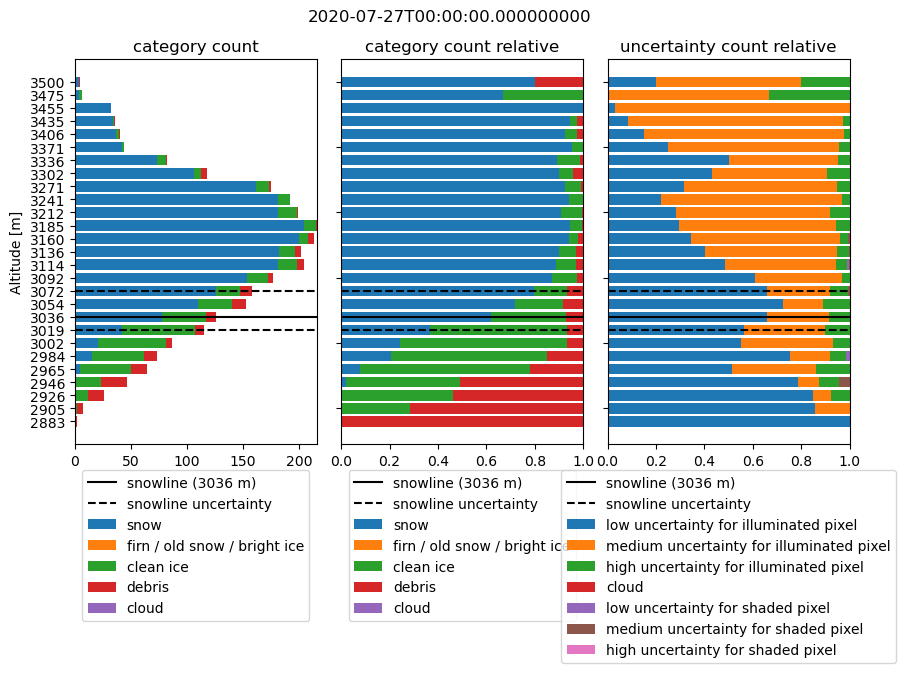

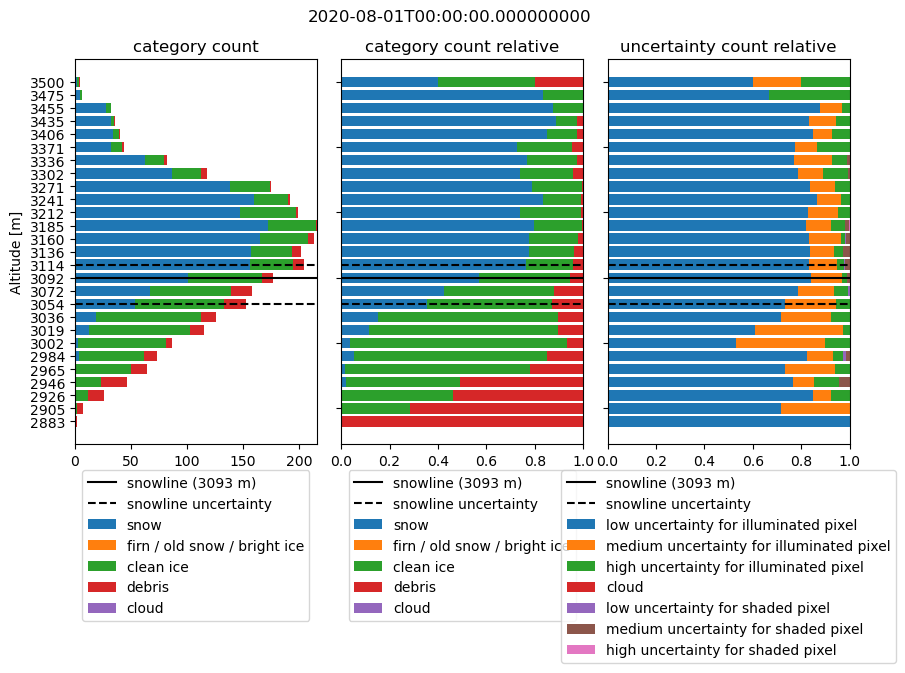

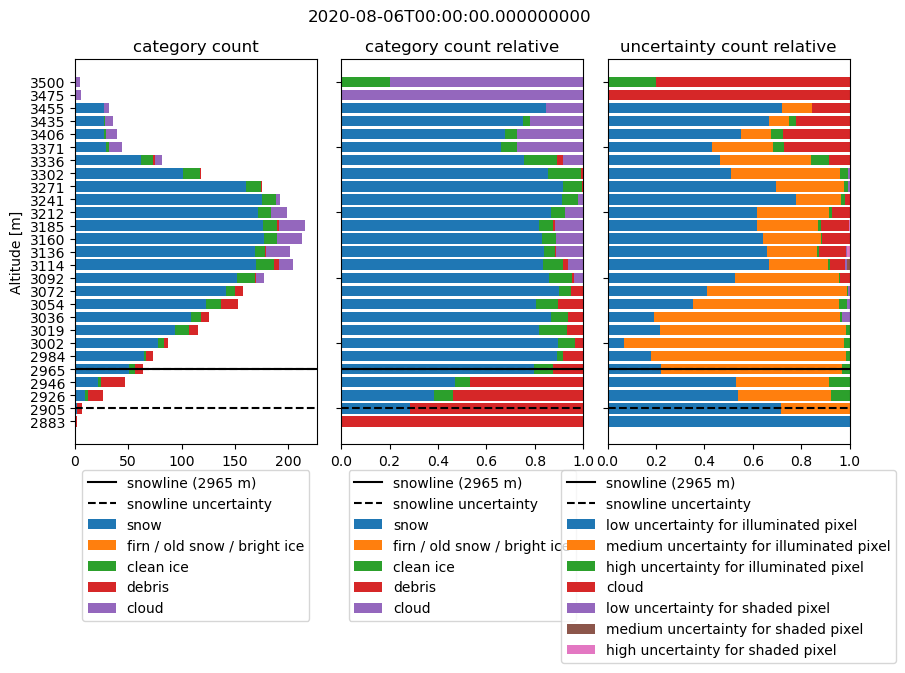

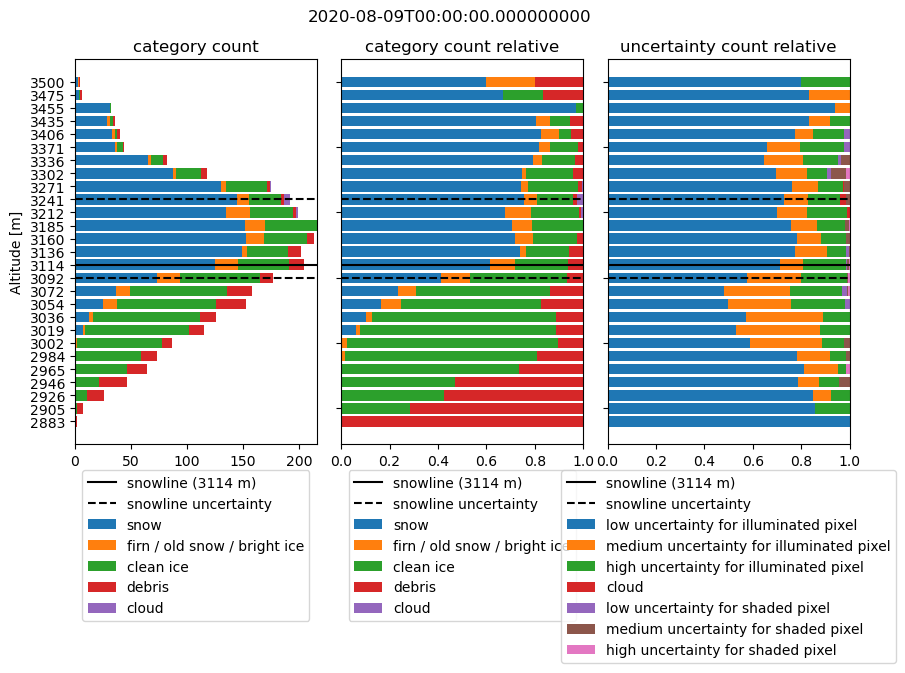

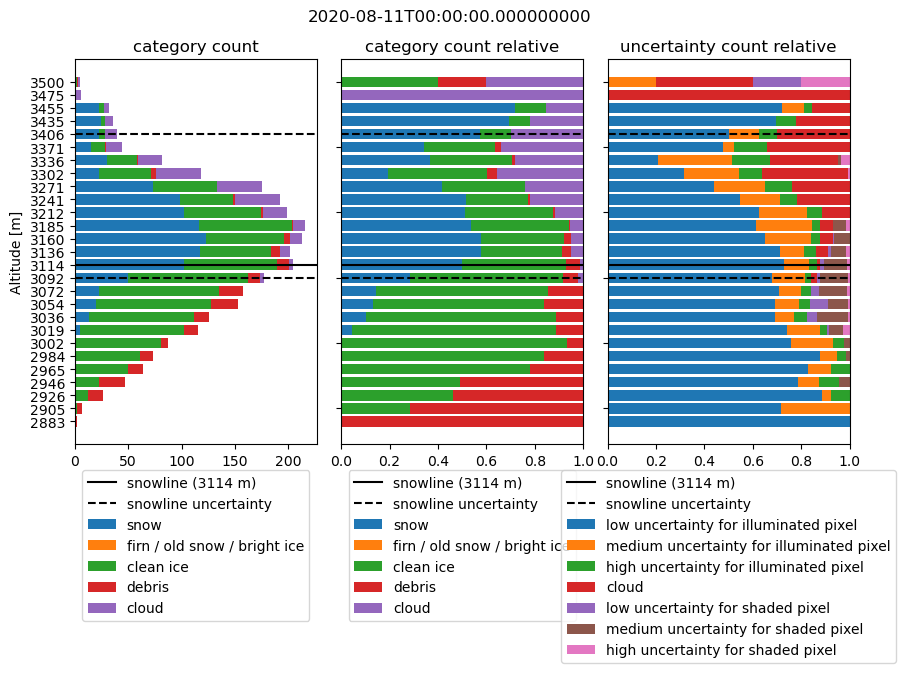

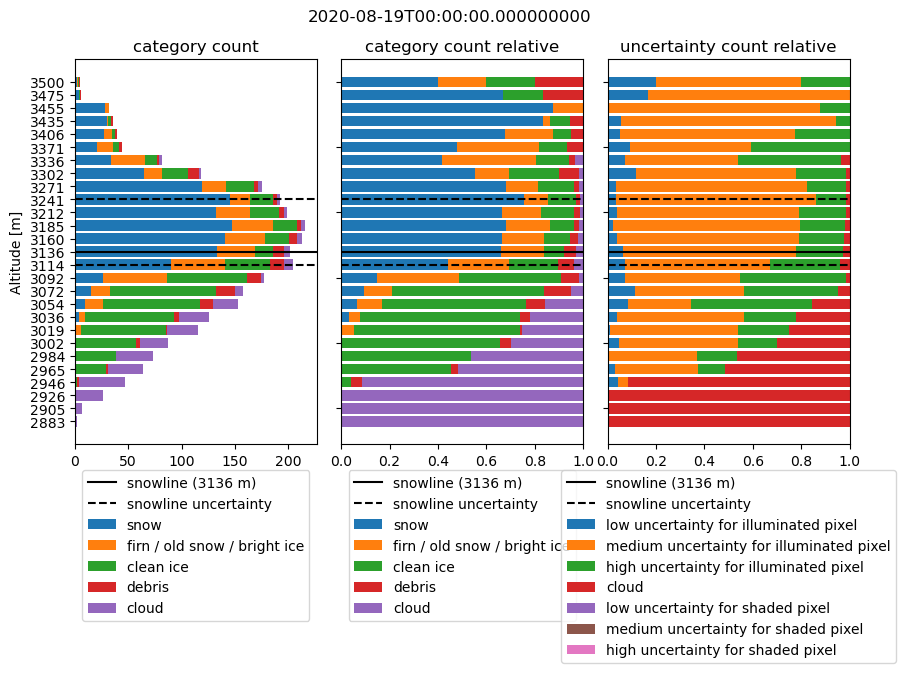

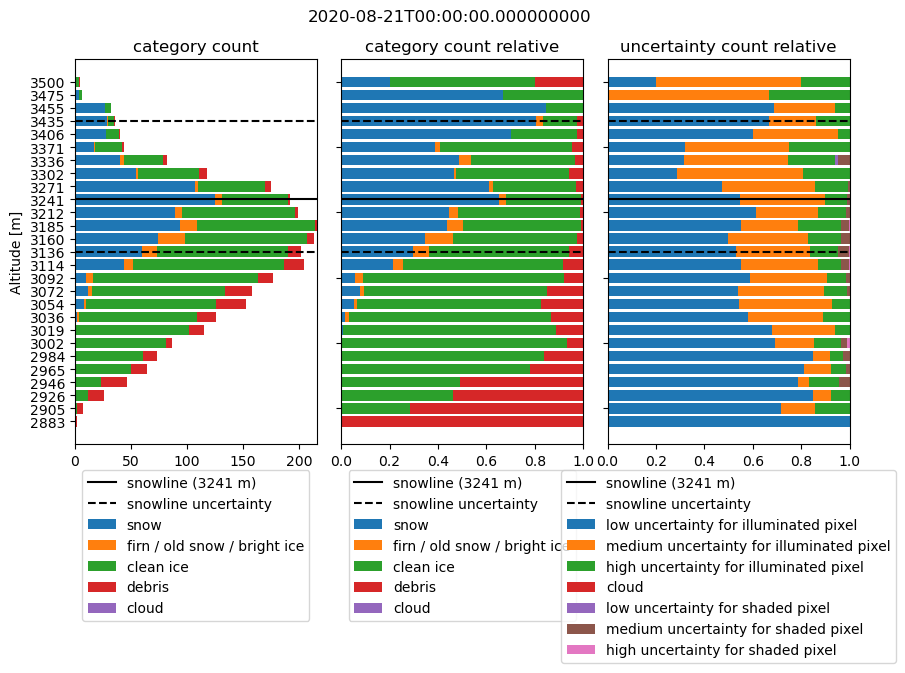

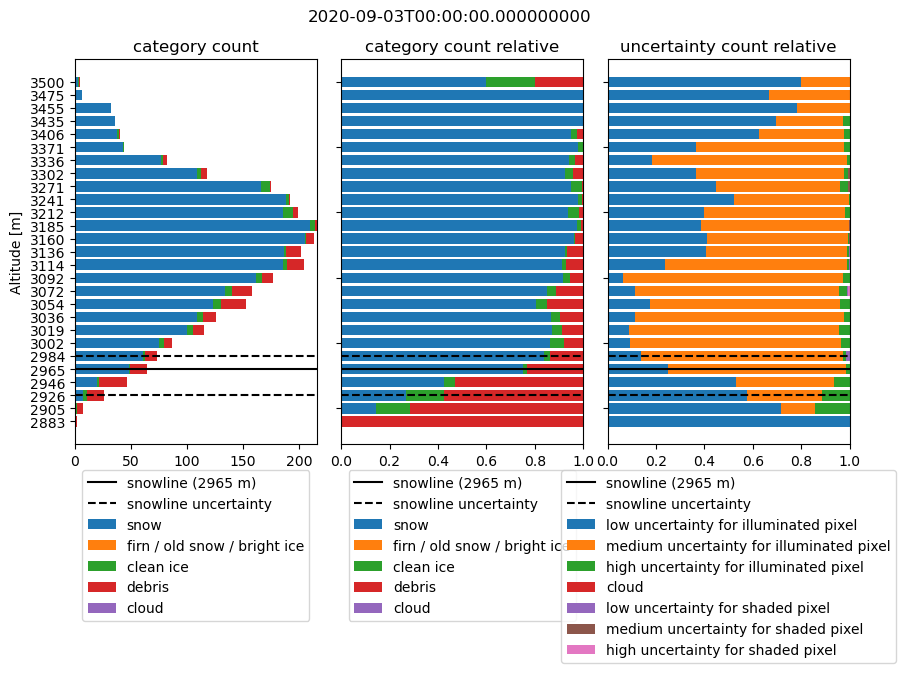

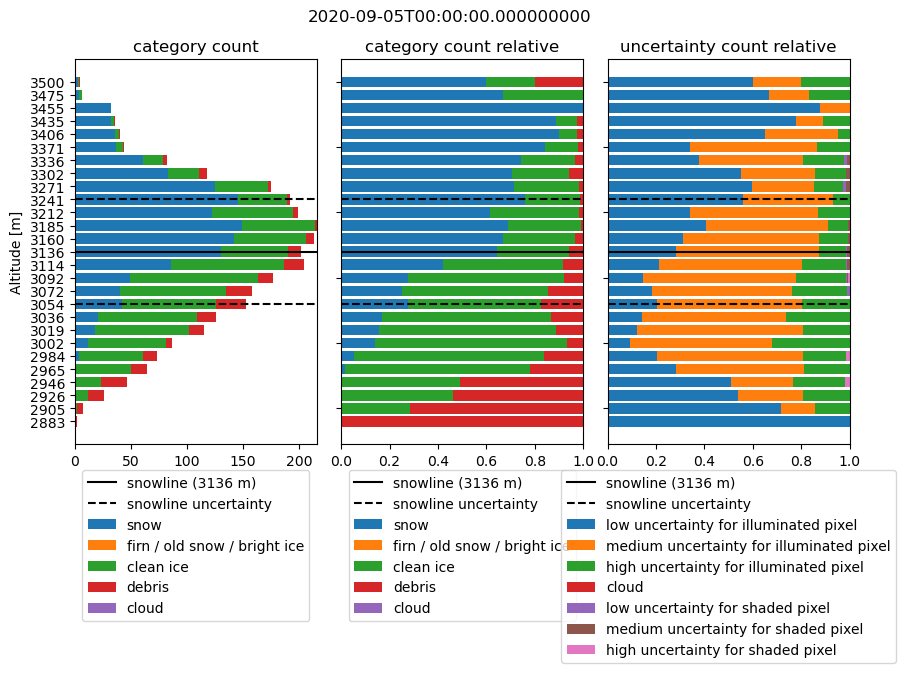

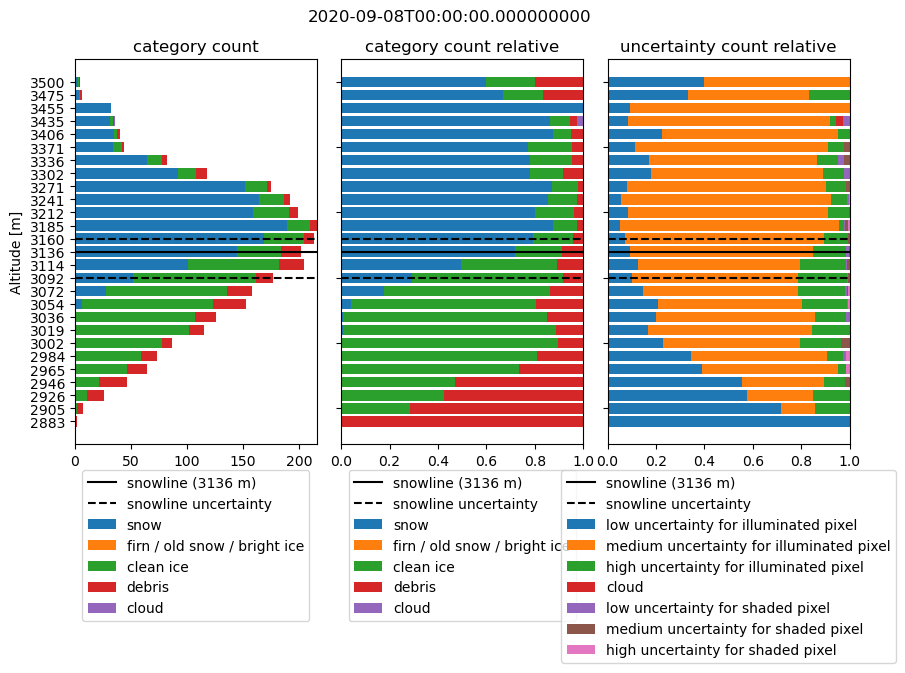

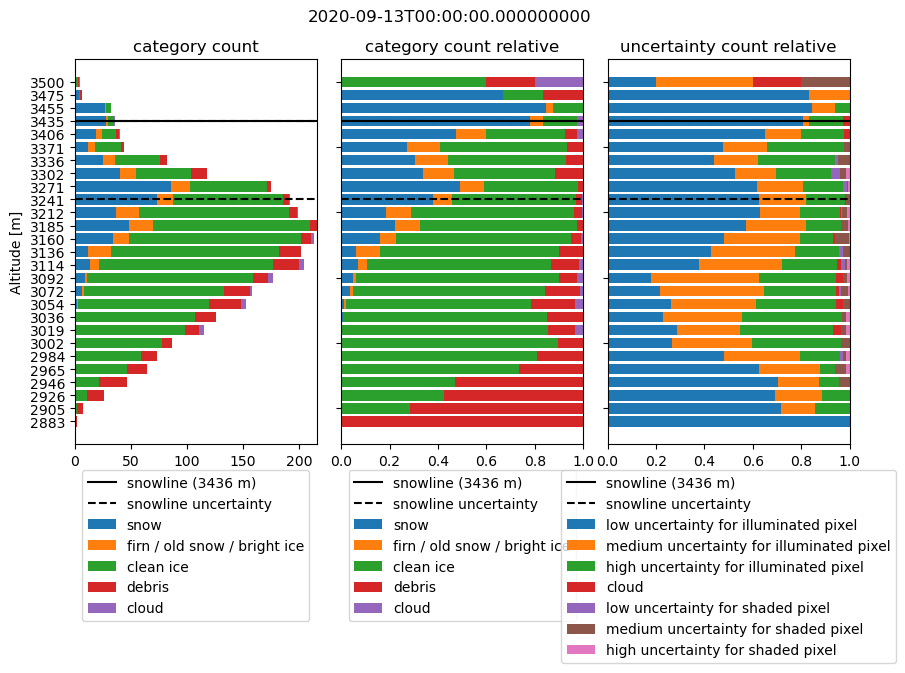

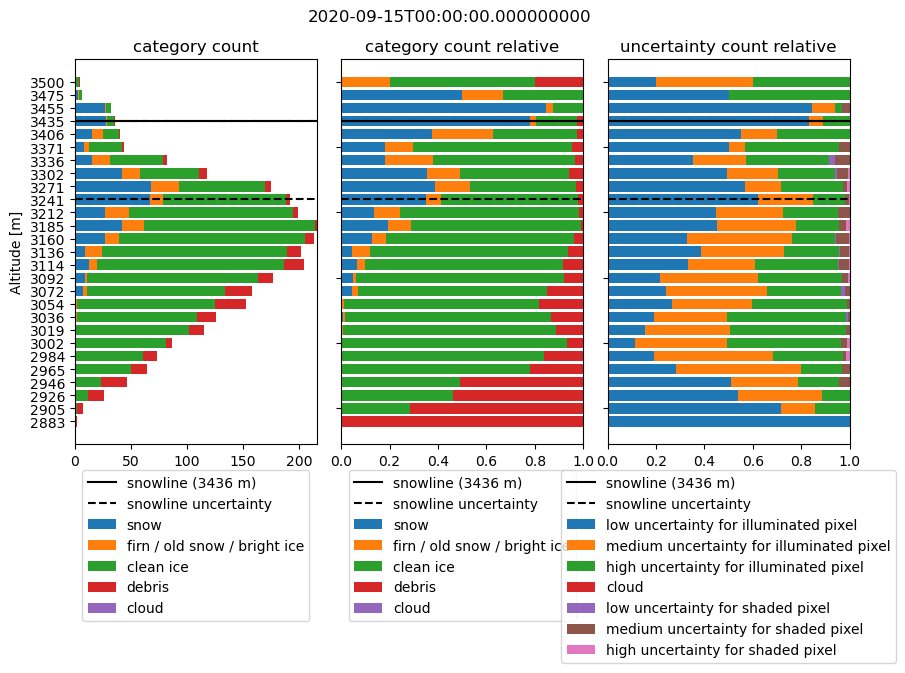

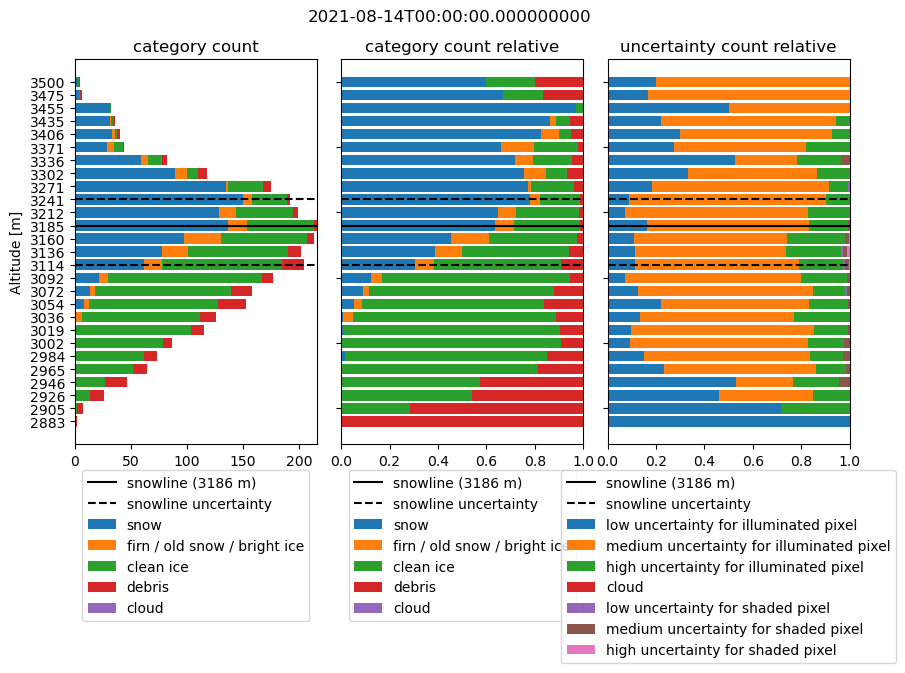

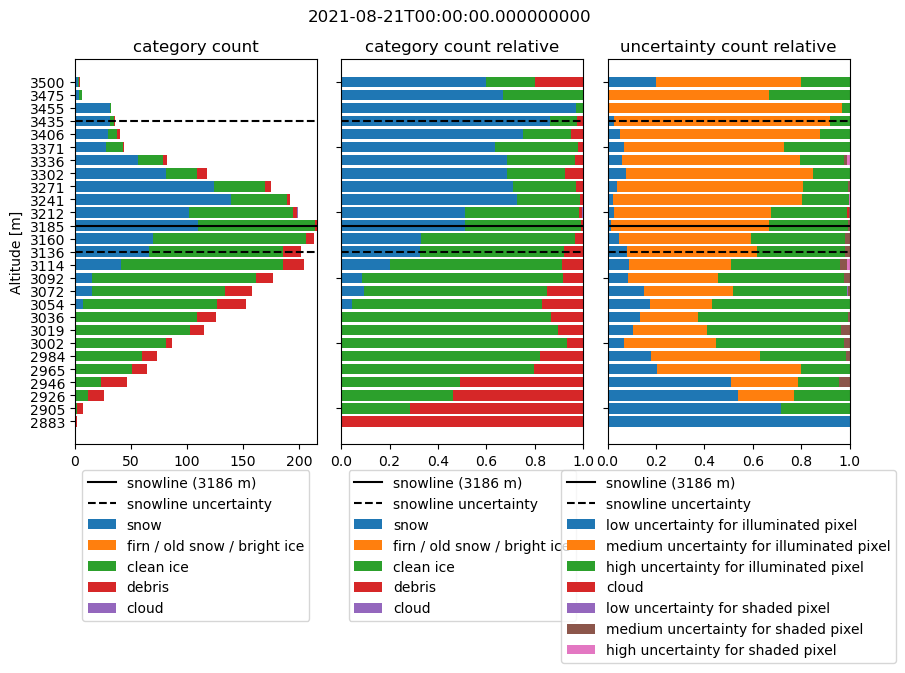

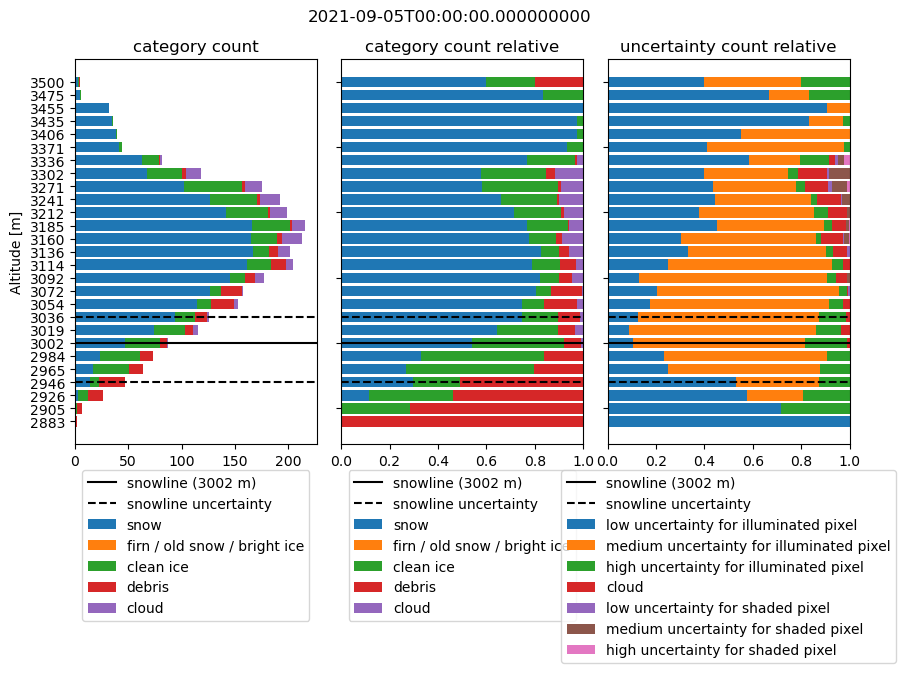

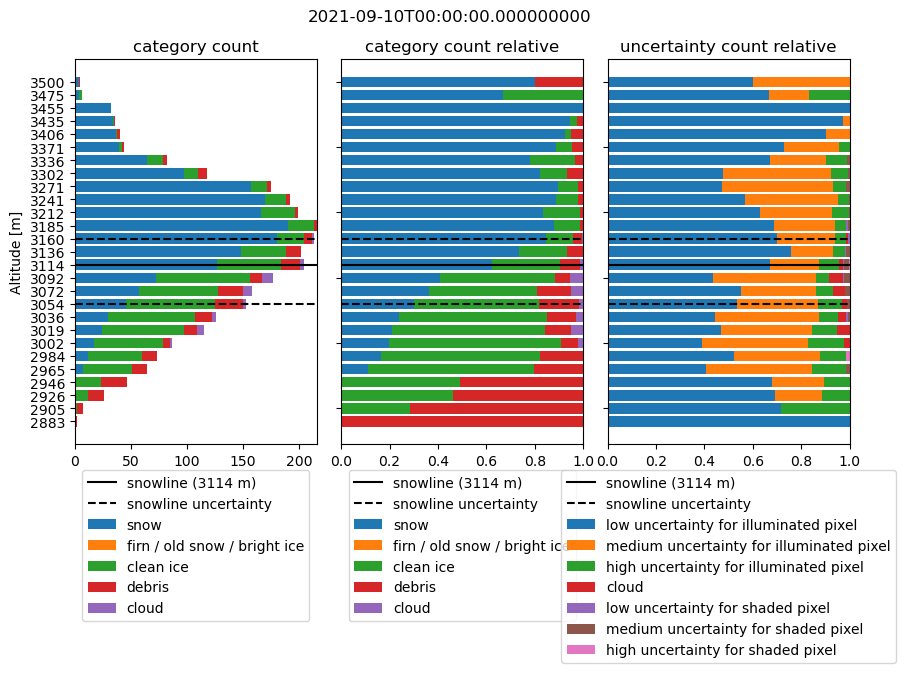

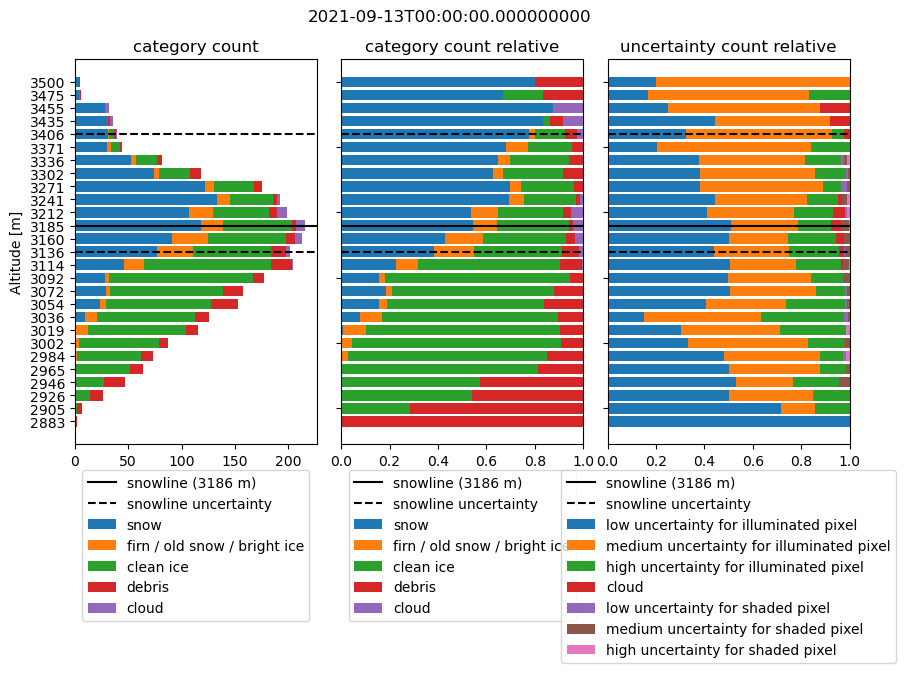

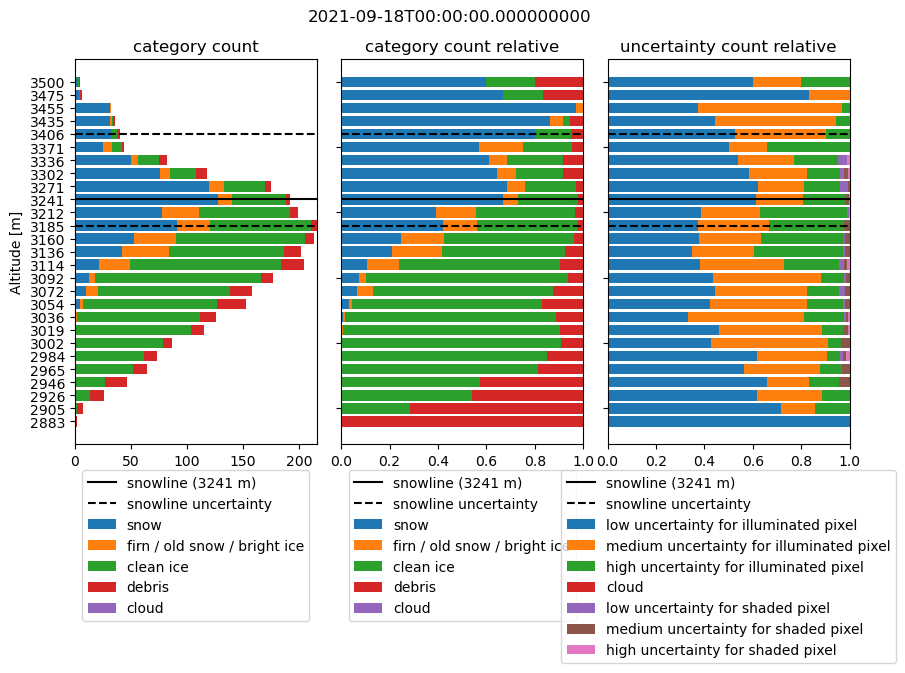

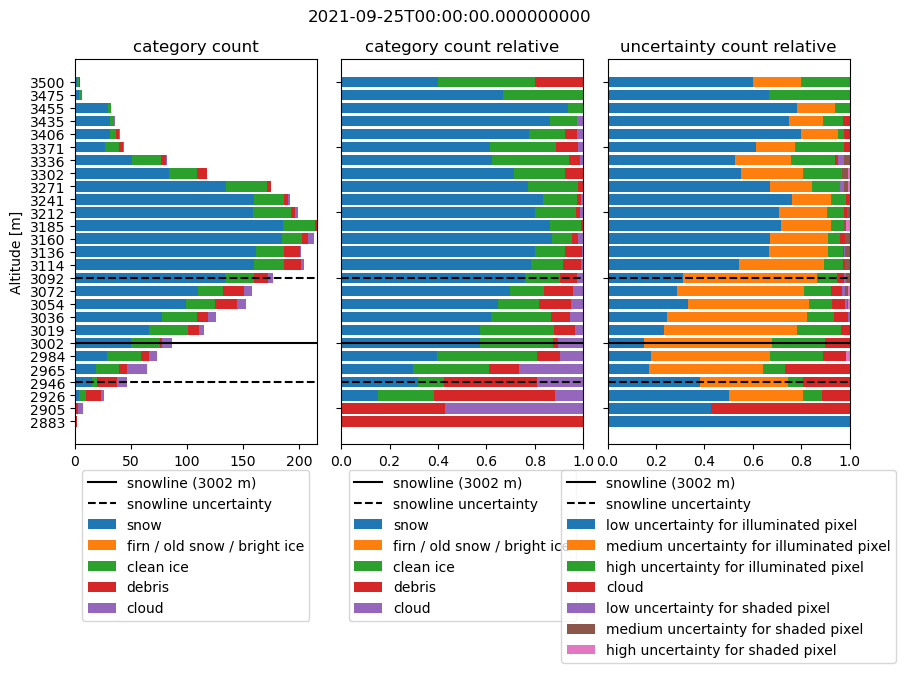

In [24]:
ds_obs = get_categories_per_elevation_band(gdir)
ds_obs = exclude_empty_elevation_bins(ds_obs)
ds_obs = exclude_dates_with_to_much_cloud_cover(ds_obs, cloud_cover=0.5)

for date in ds_obs.t_sfc_type:
    ds_use = ds_obs.sel(t_sfc_type=date)

    bin_idx, bin_elev = get_snowline(ds_use)
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace':0.1})
    
    ax_total = axs[0]
    ax_relative = axs[1]
    ax_uncertainty = axs[2]
    
    def plot_horizontal_stacked_bar(ax, ds, categories, var, normalize=False):
        category_dict = ast.literal_eval(ds[categories].attrs['code'])
        previous_values = None
        for category in ds_use[categories]:
            current_values = ds.loc[{categories: category}][var].values
            if normalize:
                number_grid_points_elev_bin = ds.category_counts.sum(dim='category')
                current_values = current_values.astype(float) / number_grid_points_elev_bin
            ax.barh(ds.elevation_bin, current_values,
                     left=previous_values,
                     label=category_dict[int(category)])
        
            if previous_values is None:
                previous_values = current_values
            else:
                previous_values = previous_values + current_values
    
        ax.invert_yaxis()
    
    plot_horizontal_stacked_bar(ax_total, ds_use, 'category', 'category_counts')
    plot_horizontal_stacked_bar(ax_relative, ds_use, 'category', 'category_counts', normalize=True)
    plot_horizontal_stacked_bar(ax_uncertainty, ds_use, 'uncertainty_flag', 'uncertainty_counts', normalize=True)

    def add_snowline(ax):
        if np.isneginf(bin_elev[1]):
            extra_label = 'fully snow covered'
        elif np.isposinf(bin_elev[1]):
            extra_label = 'fully snow free'
        else:
            extra_label = f'{bin_elev[1]:.0f} m'
        ax.axhline(bin_idx[0], color='k', linestyle='--')
        ax.axhline(bin_idx[1], color='k', linestyle='-', label=f'snowline ({extra_label})')
        ax.axhline(bin_idx[2], color='k', linestyle='--', label='snowline uncertainty')

    def set_legend(ax):
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    
    ax_total.set_yticks(ds_use.elevation_bin, [int(elev) for elev in ds_use.lower_elevation.values])
    ax_total.set_ylabel('Altitude [m]')
    ax_total.set_title('category count')
    add_snowline(ax_total)
    set_legend(ax_total)
    
    ax_relative.set_title('category count relative')
    ax_relative.set_yticklabels([])
    add_snowline(ax_relative)
    set_legend(ax_relative)
    
    ax_uncertainty.set_title('uncertainty count relative')
    ax_uncertainty.set_yticklabels([])
    add_snowline(ax_uncertainty)
    set_legend(ax_uncertainty)

    fig.suptitle(date.values)
    
    plt.show()

# Compare snowline to SfcTypeTIModel without using snowline for calibration

In [25]:
from oggm.core.massbalance import DailyTIModel, SfcTypeTIModel
from functools import partial
from oggm.utils import ModelSettings

## Get SfcTypeTIModel and calibrate

**The currently applied calibration is just a preliminary setting and will require further consideration to determine the best approach!**

At the moment, I have decided to use the precipitation factor for calibration and aim to leave the melt factor unchanged. The melt factor (the second parameter) will only be adjusted if it is not possible to match the mass balance using the precipitation factor alone.

In [26]:
# add daily climate
workflow.execute_entity_task(tasks.process_gswp3_w5e5_data,
                                 gdirs, daily=True)

2025-10-03 09:48:35: oggm.workflow: Execute entity tasks [process_gswp3_w5e5_data] on 1 glaciers
2025-10-03 09:48:35: oggm.shop.w5e5: (RGI60-11.00719) process_gswp3_w5e5_data


[None]

In [27]:
# we use the default values of OGGM prepro for the first guess variables
default_mb_calib = gdirs[0].read_json('mb_calib')

MySfcTypeTIModel = partial(
    SfcTypeTIModel,
    mb_model_class=DailyTIModel,  # options MonthlyTIModel, DailyTIModel
    climate_resolution='daily',  # how often the climate should be applied, options annual, monthly and daily
    aging_frequency='monthly',  # how often the buckets getting older, options annual and monthly
    ys=2000,  # this defines the year of where we start computing the buckets
    spinup_years=6,  # this defines how many buckets we are using and how we create the buckets for ys
    store_buckets=False,  # if you want to save buckets on the way, available with .mb_buckets_stored, options annual, monthly, daily
    store_buckets_dates=None,  # if you only save buckets at specific dates you can provide a list here in floating year convention
    use_previous_mbs=True,  # when setting this to True you can revisit an already calculated mb value
)

for gdir in gdirs:
    ModelSettings(gdir, filesuffix='_daily_sfc', parent_filesuffix='')

# now redo the calibration
workflow.execute_entity_task(
    tasks.mb_calibration_from_hugonnet_mb,
    gdirs, settings_filesuffix='_daily_sfc',
    observations_filesuffix='_dialy_sfc',  # new handling of observations
    informed_threestep=False,  # this was calibrated with monthly, but still use it
    overwrite_gdir=True,
    calibrate_param1='prcp_fac',
    calibrate_param2='melt_f',
    calibrate_param3='temp_bias',
    prcp_fac=default_mb_calib['prcp_fac'],
    melt_f=default_mb_calib['melt_f'],
    mb_model_class=MySfcTypeTIModel)

2025-10-03 09:49:29: oggm.workflow: Execute entity tasks [mb_calibration_from_hugonnet_mb] on 1 glaciers
2025-10-03 09:49:29: oggm.core.massbalance: (RGI60-11.00719) mb_calibration_from_hugonnet_mb_daily_sfc
2025-10-03 09:49:30: oggm.core.massbalance: (RGI60-11.00719) mb_calibration_from_scalar_mb_daily_sfc


[{'rgi_id': 'RGI60-11.00719',
  'bias': 0,
  'melt_f': 5.236607243012583,
  'prcp_fac': 1.3037524335399526,
  'temp_bias': 1.7583130779353044,
  'reference_mb': -913.1,
  'reference_mb_err': 154.0,
  'reference_period': '2000-01-01_2020-01-01',
  'mb_global_params': {'temp_default_gradient': -0.0065,
   'temp_all_solid': 0.0,
   'temp_all_liq': 2.0,
   'temp_melt': 0.0},
  'baseline_climate_source': 'GSWP3_W5E5_daily'}]

## Get snow buckets for observation dates

Here, I demonstrate how to obtain the model counterparts for the observations. Specifically, I create a float year time series based on the actual dates.

In [28]:
from oggm.utils import date_to_floatyear

In [29]:
# load data and exclude some stuff, the resulting dates are the one we are intereseted in
ds_obs = get_categories_per_elevation_band(gdir)
ds_obs = exclude_empty_elevation_bins(ds_obs)
ds_obs = exclude_dates_with_to_much_cloud_cover(ds_obs, cloud_cover=0.5)

# convert the dates into floatyears
dates = ds_obs.t_sfc_type.values
years = dates.astype('datetime64[Y]').astype(int) + 1970
months = dates.astype('datetime64[M]').astype(int) % 12 + 1
days = (dates.astype('datetime64[D]') - dates.astype('datetime64[M]')).astype(int) + 1

float_years = date_to_floatyear(
    y=years,
    m=months,
    d=days)

float_years_dict = dict(zip(float_years, dates))

In [30]:
# initialize the mb_model and tell which buckets we are intereseted in
mb_model = MySfcTypeTIModel(
    gdirs[0],
    settings_filesuffix='_daily_sfc',
    store_buckets=True,
    store_buckets_dates=float_years
                            )

# by calling the annual mb for 2019 all previous timesteps need to be calculated and the all buckets are available
mb_model.get_annual_mb(mb_model.fl.surface_h, year=2019);

## get modelled snowline

Here is a function for obtaining the modeled snowline.

In [31]:
from oggm.utils import floatyear_to_date

In [32]:
def get_modelled_snowline(gdir, years, settings_filesuffix):
    # initialize seleceted mb_model
    mb_model = MySfcTypeTIModel(
        gdir,
        settings_filesuffix=settings_filesuffix,
        store_buckets=True,
        store_buckets_dates=years
                            )
    # get modelled data
    mb_model.get_annual_mb(mb_model.fl.surface_h, year=2019)

    # generate snow lines
    snow_line = []
    snow_line_years = []
    for yr in years:
        try:
            mb_bucket = mb_model.mb_buckets_stored[yr]
        except KeyError:
            continue
    
        # we use all layers from October onward
        number_layers = floatyear_to_date(yr)[1] + 3  # 3 for Oct, Nov, Dec
        layers_of_interest = [f'firn_{i}' for i in range(1, number_layers + 1)]
    
        not_melted_layers = np.any(mb_bucket[layers_of_interest] > 0, axis=1)

        # check if completely snow free
        if not np.any(not_melted_layers):
            snow_line.append(np.inf)
        # check if fully snow covered
        elif np.all(not_melted_layers):
            snow_line.append(-np.inf)
        # otherwise get the lowest elevation band with snow cover
        else:
            snow_line.append(mb_model.fl.surface_h[not_melted_layers][-1])
        snow_line_years.append(yr)

    snow_line_years = np.array([float_years_dict[yr] for yr in snow_line_years])

    return snow_line, snow_line_years

In [33]:
snow_line, snow_line_years = get_modelled_snowline(
    gdir, float_years, settings_filesuffix='_daily_sfc')

## plot for comparision

A first plot for visual comparison.

Text(0, 0.5, 'Altitude [m]')

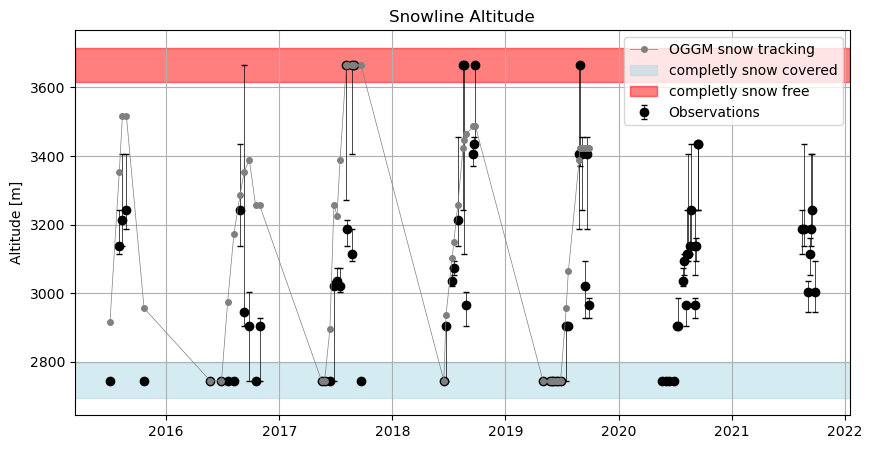

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# get observations
ds_obs = get_categories_per_elevation_band(gdir)
ds_obs = exclude_empty_elevation_bins(ds_obs)
ds_obs = exclude_dates_with_to_much_cloud_cover(ds_obs, cloud_cover=0.5)

snowline_obs = []
snowline_obs_lower = []
snowline_obs_upper = []
for date in ds_obs.t_sfc_type:
    ds_use = ds_obs.sel(t_sfc_type=date)

    tmp_idx, tmp_obs = get_snowline(ds_use)
    snowline_obs_lower.append(tmp_obs[0])  # 25% snow cover
    snowline_obs.append(tmp_obs[1])  # 50% snow cover
    snowline_obs_upper.append(tmp_obs[2])  # 75% snow cover

# get model output
snowline_mdl, snowline_mdl_years = get_modelled_snowline(
    gdir, float_years, settings_filesuffix='_daily_sfc')

# deal with special cases completely snow covered or completely snow free
all_snowlines = np.concatenate((snowline_mdl, snowline_obs_lower, snowline_obs_upper))
min_height = np.min(all_snowlines[~np.isinf(all_snowlines)])
max_height = np.max(all_snowlines[~np.isinf(all_snowlines)])
# set the plotting limit 100 apart of extreme values
neg_inf_value = min_height - 150
neg_inf_plotting_area = [min_height - 100, min_height - 200]
pos_inf_value = max_height + 150
pos_inf_plotting_area = [max_height + 100, max_height + 200]

def set_infs(var):
    var = np.where(np.isposinf(var), pos_inf_value, var)
    return np.where(np.isneginf(var), neg_inf_value, var)

# plot observations with errorbars
snowline_err = np.array(
    tuple(zip(set_infs(snowline_obs) - set_infs(snowline_obs_lower),
              set_infs(snowline_obs_upper) - set_infs(snowline_obs)))).T
ax.errorbar(ds_obs.t_sfc_type.values, set_infs(snowline_obs), yerr=snowline_err,
            fmt='o', ms=6, ecolor='black', c='k', capsize=2, lw=0.5,
            label='Observations')

# plot model output
ax.plot(snowline_mdl_years, set_infs(snowline_mdl),
        marker='o', ms=4, ls='-', lw=0.5, zorder=5, color='gray',
        label='OGGM snow tracking')

# add special areas
ax.axhspan(neg_inf_plotting_area[0], neg_inf_plotting_area[1],
           color='lightblue', alpha=0.5, label='completly snow covered')
ax.axhspan(pos_inf_plotting_area[0], pos_inf_plotting_area[1],
           color='red', alpha=0.5, label='completly snow free')

ax.legend()
ax.grid('on')
ax.set_title('Snowline Altitude')
ax.set_ylabel('Altitude [m]')

# Next Steps

The next steps would be to use the snowline observations for calibration. Some thoughts on this (open for discussion):

- Use the precipitation factor as a control parameter for matching the snowline.
- Whenever a new precipitation factor is defined, the melt factor should be calibrated to match Hugonnet before obtaining the modeled snowlines.
- When comparing observed and modeled snowlines, we need to handle special cases:
  - Fully snow-covered areas (`snowline = -np.inf`).
  - No snow cover (`snowline = np.inf`).
  - Additionally, if we want to be precise, since the outline used for creating the observations is smaller than the one we are using, if the observation shows full snow cover, we should ensure that the modeled snow cover is at least as large as the observation. However, for a first attempt, this can be ignored.
- Before minimizing automatically, check if the defined cost function has a minimum by testing an array of precipitation factors.